# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [24]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#analyse the shape of data;
#take a look at the three extra columns in customers and show the head of dataset.
print(azdias.shape, customers.shape)
print(customers[['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']].head(5))
customers.head() 

(891221, 366) (191652, 369)
  CUSTOMER_GROUP  ONLINE_PURCHASE      PRODUCT_GROUP
0    MULTI_BUYER                0  COSMETIC_AND_FOOD
1   SINGLE_BUYER                0               FOOD
2    MULTI_BUYER                0  COSMETIC_AND_FOOD
3    MULTI_BUYER                0           COSMETIC
4    MULTI_BUYER                0               FOOD


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


<font color=black size=4 face=雅黑>Visualize valid data</font>

We can see there are NAN values in many columns in the dataset from the head of DataFrame. So next we will analyse how many NANs occur in each of the column by visualization.

In [4]:
#get dataframe of non-nan values percentage in each column
nan_distribution = customers.apply(lambda x:len(x.dropna()), axis = 0)
nan_distribution.index.name = 'features'
nan_distribution_df = nan_distribution.reset_index(name = 'VALID_DATA_PERCENTAGE')
nan_distribution_df

,features,VALID_DATA_PERCENTAGE
0,LNR,191652
1,AGER_TYP,191652
2,AKT_DAT_KL,145056
3,ALTER_HH,145056
4,ALTER_KIND1,11766
5,ALTER_KIND2,5100
6,ALTER_KIND3,1275
7,ALTER_KIND4,236
8,ALTERSKATEGORIE_FEIN,139810
9,ANZ_HAUSHALTE_AKTIV,141725


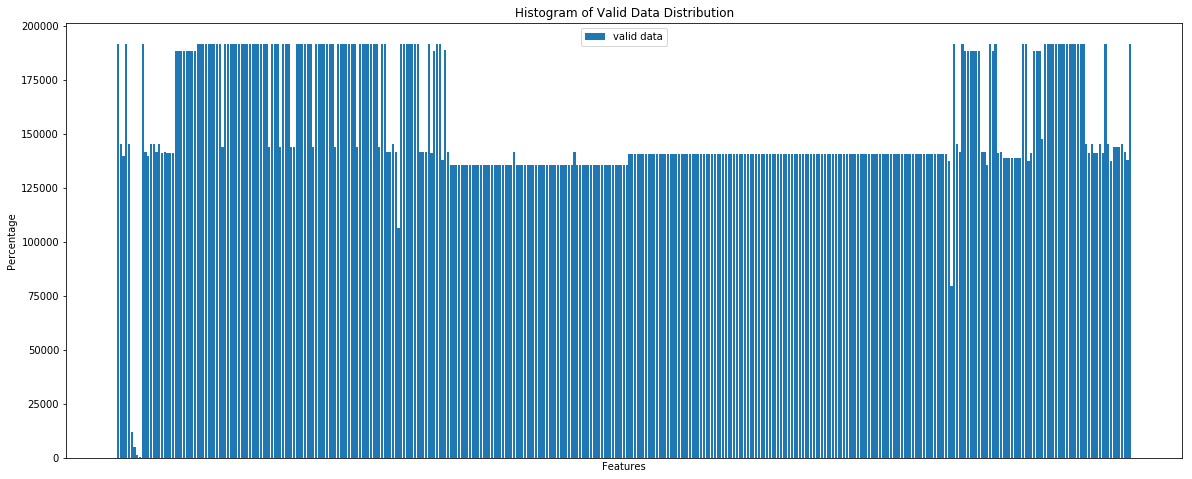

In [5]:
#Visualize valid data distribution
plt.figure(figsize = (20,8))
plt.bar(nan_distribution_df['features'], nan_distribution_df['VALID_DATA_PERCENTAGE'], label = 'valid data')
plt.xticks([])
plt.xlabel('Features')
plt.ylabel('Percentage')
title = 'Histogram of Valid Data Distribution'
plt.title(title)
plt.legend()

<font color=black size=4 face=雅黑>Preprocess the Raw Data</font>

By look at the bar graph, we can see most of features have more than 70% valid data.

Keep columns which have more than 70% valid data(not nan) in both azdias and customers set. Eliminate NAN data in both of datasets, and drop column of date:'EINGEFUEGT_AM', because it is abnormal and useless. In this way, we can keep as many features as possible without badly reducing the total number of people in the sample.

The remaining shape of dataset:(466557, 359) (118929, 362).

In [4]:
def filter_na(data):   #filter data 
    columns = []
    for feature in list(data.columns):
        if len(data[feature].dropna()) > 7./10*len(data):
            columns.append(feature)
    return columns

columns_az = filter_na(azdias)  
columns_cu = filter_na(customers)
print('Length of remaining azdias columns:{}, Length of remaining customers columns:{}'.format(len(columns_az), len(columns_cu)))

common = list(set(columns_az).intersection(columns_cu))
common_customers = common.copy()
[common_customers.append(i) for i in ['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']]
print('Length of remaining azdias columns:{}, length of remaining customers columns:{}'.format(len(common), len(common_customers)))

Length of remaining azdias columns:360, Length of remaining customers columns:363
Length of remaining azdias columns:360, length of remaining customers columns:363


In [5]:
customers_df = customers[common_customers].dropna(axis = 0)
azdias_df = azdias[common].dropna(axis = 0)
print(customers_df.shape, azdias_df.shape)   #get data without NAN

(118961, 363) (466724, 360)


In [6]:
customers_df = customers_df.reset_index().iloc[:,1:]
azdias_df = azdias_df.reset_index().iloc[:,1:]
customers_df.head()           #reset index of data

,KBA13_AUTOQUOTE,KBA13_SEG_GROSSRAUMVANS,KBA13_GBZ,D19_KONSUMTYP,KBA13_PEUGEOT,D19_LEBENSMITTEL,EWDICHTE,KBA05_CCM4,D19_TECHNIK,KBA13_BMW,...,KBA13_ALTERHALTER_61,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HHZ,RETOURTYP_BK_S,D19_VERSAND_REST,D19_VERSAND_ANZ_24,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,4.0,5.0,5.0,3.0,2.0,6,2.0,1.0,6,5.0,...,3.0,0.0,3.0,5.0,5.0,0,0,MULTI_BUYER,0,COSMETIC_AND_FOOD
1,2.0,3.0,2.0,3.0,5.0,0,4.0,2.0,0,4.0,...,4.0,0.0,2.0,3.0,5.0,0,0,MULTI_BUYER,0,COSMETIC_AND_FOOD
2,3.0,4.0,3.0,1.0,3.0,5,4.0,0.0,6,3.0,...,4.0,10.0,0.0,3.0,5.0,3,5,MULTI_BUYER,0,FOOD
3,2.0,3.0,5.0,2.0,4.0,0,5.0,4.0,6,4.0,...,3.0,0.0,2.0,5.0,3.0,0,1,MULTI_BUYER,0,COSMETIC_AND_FOOD
4,3.0,4.0,5.0,2.0,5.0,6,2.0,1.0,7,4.0,...,3.0,7.0,3.0,5.0,5.0,0,2,MULTI_BUYER,0,COSMETIC_AND_FOOD


In [7]:
azdias_df = azdias_df.drop(['EINGEFUEGT_AM'], axis = 1)
customers_df = customers_df.drop(['EINGEFUEGT_AM'], axis = 1)
print(customers_df.shape, azdias_df.shape)   #drop Date column

(118961, 362) (466724, 359)


Get abnormal columns(type in object or str) where the values can not be calculated. Then show the unique values in each of columns, transform them into specific numbers to make them computable. 

*Special case for two extra columns in Customers*: For 'CUSTOMER_GROUP' column, we define 'SINGLE_BUYER' as 1, and 'MULTI_BUYER' as 2. For  'PRODUCT_GROUP' column, we define 'FOOD' and 'COSMETIC' as 1 and 'COSMETIC_AND_FOOD' as 2. I use this type of score because a person assumes more kinds of prducts tends to have a higher possiblity to be a customers in the future. 
Other columns we just sort their values and give them a number from 1 to maximum. 

In [20]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False    #function can recognize a value is number or not

In [18]:
def get_str_columns(data):   #get columns need to be numeralized
    str_columns = []
    for feature in list(data.columns):
        column = data[feature]
        if column.dtype == object:
            str_columns.append(feature)
    return str_columns

str_columns_azdias = get_str_columns(azdias_df)
str_columns_customers = get_str_columns(customers_df)
print('Values in these azdias columns should be numeralized:{}, \
       values in these customers columns should be numeralized:{}'.format(str_columns_azdias, str_columns_customers))

In [16]:
#for column with all str type, numerilize it after sorting its value;
#for column with a mixed type(str values and number values), numerilize its number strs(like '1') and tansform other strs(like 'a') to NAN
def delet_str(data, str_columns):     
    for feature in str_columns:
        column = data[feature].copy()
        
        if column.dtype == object:
            if feature not in ['CUSTOMER_GROUP', 'PRODUCT_GROUP']:   
                values = column.unique().tolist()
                if np.mean([type(j) == str for j in values]) == 1.0:  #if it is a column noly has str type, sort its value and numerlize it
                    values.sort()
                    for i in range(len(values)):
                        column[column == values[i]] = i + 1
                else:                                          #recognize a column mixed with number str and other str
                    for i in values:
                        if is_number(i):
                            column[column == i] = np.float32(i)
                        else:
                            column[column == i] = np.nan
                
            elif feature == 'PRODUCT_GROUP':                     #two special cases
                column[column == 'COSMETIC_AND_FOOD'] = 2
                column[column == 'COSMETIC'] = 1
                column[column == 'FOOD'] = 1
            
            elif feature == 'CUSTOMER_GROUP':
                column[column == 'MULTI_BUYER'] = 2
                column[column == 'SINGLE_BUYER'] = 1
        
        data[feature] = column.astype(np.float32)
        print('{} colunm has been finished'.format(feature))
    return data

In [11]:
azdias_ = delet_str(azdias_df, str_columns_azdias)
customers_ = delet_str(customers_df, str_columns_customers)
azdias_ = azdias_.dropna()
customers_ = customers_.dropna()
print('Shape of azdias:{}; Shape of customers:{}'.format(azdias_.shape, customers_.shape))
print('All of the columns in azdias are numeral:{}'.format((len(get_str_columns(azdias_)) == 0)&(len(get_str_columns(customers_)) == 0)))

OST_WEST_KZ colunm has been finished
CAMEO_DEU_2015 colunm has been finished
D19_LETZTER_KAUF_BRANCHE colunm has been finished
CAMEO_INTL_2015 colunm has been finished
CAMEO_DEUG_2015 colunm has been finished
OST_WEST_KZ colunm has been finished
CAMEO_DEU_2015 colunm has been finished
D19_LETZTER_KAUF_BRANCHE colunm has been finished
CAMEO_INTL_2015 colunm has been finished
CAMEO_DEUG_2015 colunm has been finished
CUSTOMER_GROUP colunm has been finished
PRODUCT_GROUP colunm has been finished
Shape of azdias:(466557, 359); Shape of customers:(118929, 362)
All of the columns in azdias are numeral:True


In [22]:
#compress values from float64 to float32
def compress_data(data):
    out = pd.DataFrame()
    chunk = 20000
    i = 1
    while chunk*(i - 1) < len(data):
        if i*chunk < len(data):
            part_ = data.iloc[(i-1)*chunk:i*chunk, :].copy()
        else:
            part_ = data.iloc[(i-1)*chunk:, :].copy()
        part_ = part_.astype(np.float32)
        out = pd.concat([out,part_])
        i += 1
    return out

In [13]:
azdias_compressed = compress_data(azdias_)
customers_compressed = compress_data(customers_)

In [14]:
print(azdias_compressed.shape, customers_compressed.shape)

(466557, 359) (118929, 362)


<font color=black size=4 face=雅黑>Visualizing the Data</font>

We plot the distribution of some features--'CAMEO_INTL_2015', 'OST_WEST_KZ', 'PRODUCT_GROUP' and 'VK_DHT4A' Arvato customers currently have.

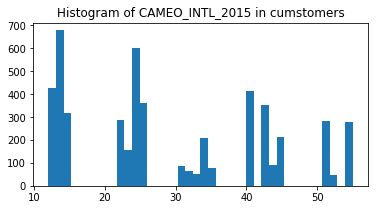

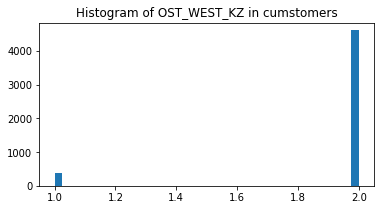

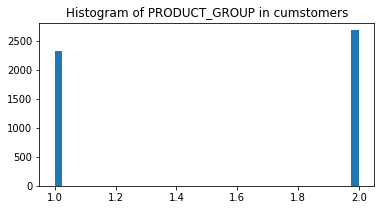

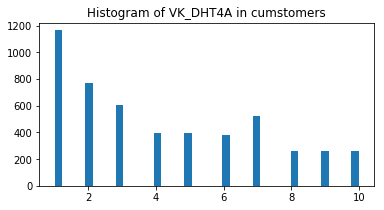

In [17]:
# get some features to visualize 
features_list = ['CAMEO_INTL_2015', 'OST_WEST_KZ', 'PRODUCT_GROUP', 'VK_DHT4A']
n_bins = 40

for column in features_list:
    ax = plt.subplots(figsize=(6,3))
    ax = plt.hist(customers_compressed.iloc[:5000,:][column], bins=n_bins)
    title = "Histogram of " + column + " in cumstomers"
    plt.title(title, fontsize=12)

<font color=black size=4 face=雅黑>Normalize the data</font>

Transform values in each of the dataset into scaled numbers between 0 to 1.

In [15]:
scaler = MinMaxScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_compressed.astype(np.float32)))
azdias_scaled.columns = azdias_compressed.columns
azdias_scaled.index = azdias_compressed.index

azdias_scaled.head()

,KBA13_AUTOQUOTE,KBA13_SEG_GROSSRAUMVANS,KBA13_GBZ,D19_KONSUMTYP,KBA13_PEUGEOT,D19_LEBENSMITTEL,EWDICHTE,KBA05_CCM4,D19_TECHNIK,KBA13_BMW,...,CJT_TYP_4,KBA13_BJ_2008,KBA13_CCM_1500,KBA13_ALTERHALTER_61,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HHZ,RETOURTYP_BK_S,D19_VERSAND_REST,D19_VERSAND_ANZ_24
0,0.50,0.50,0.75,1.000,0.50,0.0,0.6,0.000000,0.857143,0.75,...,0.50,0.6,0.75,0.50,0.0,0.8,0.75,0.50,0.000000,0.000000
1,0.50,0.50,0.50,0.000,0.50,0.0,0.8,0.222222,0.714286,0.25,...,0.75,0.0,0.75,0.50,1.0,0.6,0.50,1.00,0.285714,1.000000
2,0.50,0.75,1.00,0.375,0.75,0.0,0.2,0.000000,0.000000,0.75,...,1.00,0.8,0.50,0.50,0.0,0.6,1.00,0.50,0.000000,0.000000
3,0.75,0.50,0.75,1.000,0.25,0.0,0.8,0.000000,0.857143,0.75,...,0.75,0.6,0.75,0.75,0.0,1.0,0.75,1.00,0.000000,0.000000
4,0.50,0.00,0.50,0.250,0.75,0.0,0.8,0.444444,0.857143,1.00,...,0.00,1.0,0.75,1.00,1.0,0.2,0.50,0.75,0.000000,0.333333


In [16]:
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_compressed.astype(np.float32)))
customers_scaled.columns = customers_compressed.columns
customers_scaled.index = customers_compressed.index

customers_scaled.head()

,KBA13_AUTOQUOTE,KBA13_SEG_GROSSRAUMVANS,KBA13_GBZ,D19_KONSUMTYP,KBA13_PEUGEOT,D19_LEBENSMITTEL,EWDICHTE,KBA05_CCM4,D19_TECHNIK,KBA13_BMW,...,KBA13_ALTERHALTER_61,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HHZ,RETOURTYP_BK_S,D19_VERSAND_REST,D19_VERSAND_ANZ_24,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,0.75,1.00,1.00,0.250,0.25,0.857143,0.2,0.111111,0.857143,1.00,...,0.50,0.0,0.6,1.0,1.0,0.000000,0.000000,1.0,0.0,1.0
1,0.25,0.50,0.25,0.250,1.00,0.000000,0.6,0.222222,0.000000,0.75,...,0.75,0.0,0.4,0.5,1.0,0.000000,0.000000,1.0,0.0,1.0
2,0.50,0.75,0.50,0.000,0.50,0.714286,0.6,0.000000,0.857143,0.50,...,0.75,1.0,0.0,0.5,1.0,0.428571,0.833333,1.0,0.0,0.0
3,0.25,0.50,1.00,0.125,0.75,0.000000,0.8,0.444444,0.857143,0.75,...,0.50,0.0,0.4,1.0,0.5,0.000000,0.166667,1.0,0.0,1.0
4,0.50,0.75,1.00,0.125,1.00,0.857143,0.2,0.111111,1.000000,0.75,...,0.50,0.7,0.6,1.0,1.0,0.000000,0.333333,1.0,0.0,1.0


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<font color=black size=4 face=雅黑>Outline of Part 1</font>

In this section, I will do tow main tasks. The first is to get a better idea of what kinds of features are more important to determine whether a person is likely to be a customer of the company, and the second is to find some patterns of customers. My work is as follows:

- Firstly, I will conduct a PCA algorithm to reduce the dimension of customers dataset to make it more efficient to implement K-Means method.
- Then, clustering the customers data and get some classed that can indicate special characteristics of the group of buyers.
- Thrid, by computing and ranking weights of original features in each cluster, I can get a series of good values that can better predict whether a person is a potential customers. In this way, we can finish the first task.
- Finally, I will build an unspervised learning model again, using azdias dataset. Then I will predict which clusters people belong with in customers set. We can get some insights by comparing the segmentation of two dataset. For instance, if the percentage of customers in one cluster is much larger than the percentage of people in the same clsuter in azdias, we can see customers gather in this cluster and people with top features in this clsuter are more likely to be a customer.


<font color=black size=4 face=雅黑>1. PCA Analysis</font>

Before conducting the clustering method, I will do PCA analysis to reduce the dimension of customers data in order to promote the efficiency of clustering calculation. In this project, I will select 149 components, which can explain at least 90% the total features.

In [20]:
customers_values = customers_scaled.iloc[:,:-3]  #get metrics of customer features
print('shape of customers values:{}'.format(customers_values.shape))

pca = PCA()
all_pca = pca.fit_transform(customers_values)   #get pca values
print('pca values:\n{}'.format(all_pca))
exp_var_ratio = pca.explained_variance_ratio_       #get PC-Contribution 
print('pc_contribution ratio:\n{}'.format(exp_var_ratio))

shape of customers values:(118929, 359)
pca values:
[[ -3.13539446e-01  -2.14944016e+00   6.75022575e-01 ...,  -7.56020858e-04
   -1.47145793e-04   2.94491544e-15]
 [  2.35080236e+00  -5.30284764e-01  -7.74289105e-03 ...,  -9.89225405e-05
    6.87642604e-04  -1.79230395e-15]
 [ -4.40331104e-01   2.74124882e+00  -1.07220172e+00 ...,  -2.32824088e-03
   -6.97546503e-04  -1.11037347e-15]
 ..., 
 [  2.30398099e-01  -9.13187026e-01   1.60384579e-01 ...,  -1.85234303e-04
    3.26781468e-04  -4.58591530e-17]
 [  5.16816043e-01   1.05438541e+00  -7.95182552e-01 ...,   6.67892386e-03
   -7.59366338e-04   2.23218854e-16]
 [ -1.43333633e+00  -1.05887792e+00  -6.21464762e-01 ...,   4.17151822e-04
   -6.61613609e-05   5.02862796e-16]]
pc_contribution ratio:
[  9.08329693e-02   5.72810498e-02   5.32545499e-02   3.17635694e-02
   2.65705577e-02   2.18993027e-02   2.15373974e-02   2.03349239e-02
   1.51550741e-02   1.43449136e-02   1.33653808e-02   1.17602575e-02
   1.13182497e-02   1.00610298e-02   9

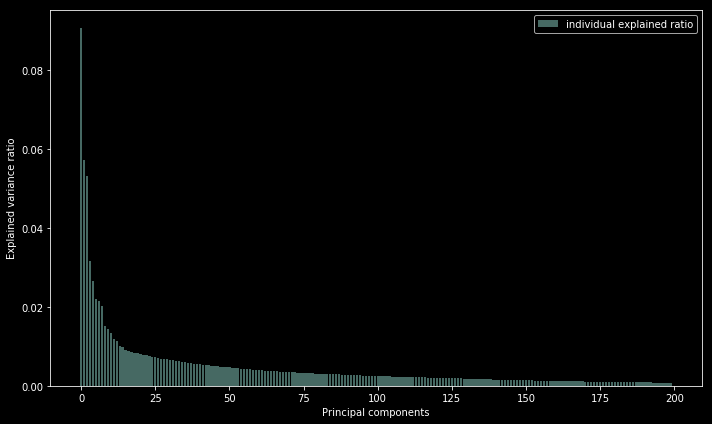

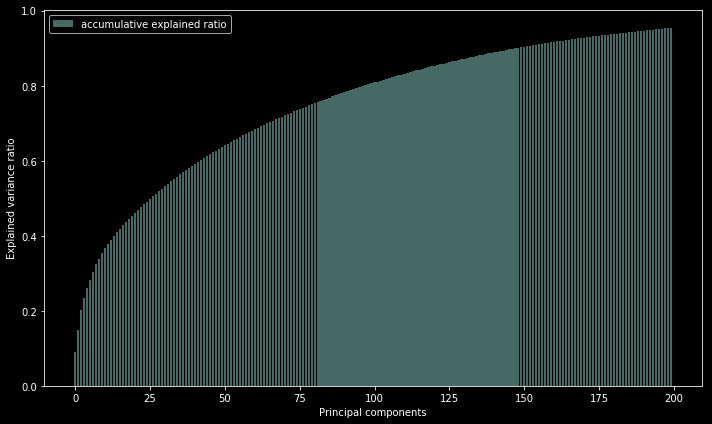

In [21]:
with plt.style.context('dark_background'):  #plot first 200 contributions
    plt.figure(figsize=(10, 6))
    plt.bar(range(200), exp_var_ratio[:200], alpha=0.5, label='individual explained ratio')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

with plt.style.context('dark_background'):  #plot accumulative contributions of first 200 principal components
    plt.figure(figsize=(10, 6))
    plt.bar(range(200), exp_var_ratio[:200].cumsum(), alpha=0.5, label='accumulative explained ratio')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [22]:
#get n components which can explain the data in more than 90% scope.
cum_exp_var_ratio = exp_var_ratio.cumsum()
n = (cum_exp_var_ratio < 0.9).sum() + 1
print('{} principal components can {}% cover the values of data'.format(n, cum_exp_var_ratio[n - 1]*100))

149 principal components can 90.10796737947281% cover the values of data


In [23]:
#get 149 principal components of the customers data
pca_n = PCA(n_components = n)
pc_values = pca_n.fit_transform(customers_values)
print('pca values:\n{}'.format(pc_values))
pc_weights = pca_n.components_
print('features weights of pcs:\n{}'.format(pc_weights.T))

pca values:
[[-0.31353944 -2.14944015  0.6750226  ...,  0.03929909 -0.08115114
  -0.15773929]
 [ 2.35080237 -0.53028481 -0.00774285 ..., -0.00652445 -0.55987385
   0.18463776]
 [-0.4403311   2.74124876 -1.0722017  ..., -0.02789844  0.084849
  -0.04831307]
 ..., 
 [ 0.2303981  -0.91318699  0.16038454 ...,  0.16776044 -0.02520618
  -0.14523413]
 [ 0.51681604  1.05438538 -0.79518258 ...,  0.46092512  0.12564147
  -0.16276628]
 [-1.43333633 -1.05887792 -0.62146476 ..., -0.1452892   0.2799872
   0.03605443]]
features weights of pcs:
[[ 0.00213185 -0.00468724  0.14117126 ...,  0.03925911  0.00166855
   0.00057756]
 [ 0.04835198 -0.00139131 -0.03405664 ..., -0.00019551 -0.02941778
  -0.04341675]
 [-0.03775974  0.02818441  0.00420966 ..., -0.02191199  0.00743405
   0.00320055]
 ..., 
 [ 0.02533738 -0.0379326  -0.00133904 ...,  0.01645988  0.01051633
  -0.00777345]
 [-0.01253326  0.02721936  0.00359052 ..., -0.02592761  0.02972193
  -0.00559096]
 [-0.01062436  0.01411511  0.00117349 ...,  0.014

In [24]:
#get component makeup DataFrame
weights_df = pd.DataFrame(pc_weights)
weights_df.columns = customers_values.columns
components_list = ['top ' + str(i+1) + ' component' for i in range(len(weights_df))]
weights_df.index = components_list
weights_df

features,KBA13_CCM_2501,VK_ZG11,D19_BIO_OEKO,KBA13_BJ_2008,KBA13_ALTERHALTER_61,AKT_DAT_KL,D19_VERSI_DATUM,D19_VERSI_ONLINE_QUOTE_12,KBA05_HERSTTEMP,INNENSTADT,...,KBA05_SEG3,CJT_TYP_5,D19_SONSTIGE,LP_STATUS_FEIN,KBA13_SEG_OBERKLASSE,D19_VERSAND_DATUM,SHOPPER_TYP,D19_BANKEN_ONLINE_DATUM,UNGLEICHENN_FLAG,D19_BANKEN_ANZ_12
top 1 component,0.002132,0.048352,-0.037760,-0.009318,0.034741,0.017180,0.045352,-8.372630e-04,0.004870,-0.075042,...,0.007725,0.007100,-0.031317,-0.158283,0.023996,0.128660,0.010290,0.025337,-0.012533,-0.010624
top 2 component,-0.004687,-0.001391,0.028184,-0.015797,0.013651,0.018304,-0.035580,9.977474e-04,0.004496,-0.074431,...,0.001421,-0.095351,-0.008757,-0.123705,0.017105,-0.167632,0.011685,-0.037933,0.027219,0.014115
top 3 component,0.141171,-0.034057,0.004210,0.079753,0.108598,-0.006564,0.006225,2.020884e-07,-0.015614,-0.075467,...,-0.022795,0.032498,0.025673,0.058016,0.143296,-0.008395,0.009274,-0.001339,0.003591,0.001173
top 4 component,0.083973,0.083314,-0.022069,0.036862,-0.019538,0.032447,-0.001773,4.090440e-05,-0.000880,0.052926,...,-0.002883,-0.093952,-0.075771,-0.028684,0.046356,-0.008413,0.014108,-0.003441,0.005600,-0.001143
top 5 component,0.023213,0.075270,-0.041042,-0.012332,-0.042808,0.028861,-0.011294,1.505579e-04,0.001699,0.013343,...,-0.006556,-0.128450,-0.067054,-0.002920,0.009222,0.041046,-0.095158,-0.007572,0.020334,0.000048
top 6 component,0.126094,-0.043920,0.030944,-0.014353,-0.096626,-0.016889,-0.018427,1.748318e-04,-0.003108,0.099548,...,0.008165,0.072713,0.039014,-0.139452,0.043595,-0.026747,0.000085,0.001277,-0.014826,0.001427
top 7 component,0.015190,0.013680,0.039608,-0.015346,-0.034280,0.011608,-0.010033,-2.901338e-04,-0.003123,0.003562,...,-0.004608,-0.080198,0.049321,0.010049,0.010853,0.182590,0.018458,0.013226,0.077703,-0.003815
top 8 component,-0.036259,-0.013027,0.007310,0.071761,-0.064178,0.000549,-0.011604,5.028355e-05,0.002327,0.014838,...,0.019524,0.000932,0.012468,-0.081351,-0.035366,0.002206,-0.002481,0.001301,-0.007976,-0.000046
top 9 component,-0.005430,-0.030959,0.062052,0.020854,0.042943,0.014246,0.004994,-3.729106e-04,0.003839,0.000480,...,-0.001400,-0.086325,0.094621,-0.010796,-0.005435,0.048286,-0.053388,0.005783,-0.041280,-0.003002
top 10 component,-0.059328,0.007936,0.018083,-0.096008,0.226452,0.003414,-0.011611,1.465566e-04,-0.010719,0.019423,...,-0.006473,-0.010895,0.000798,-0.136015,0.017008,0.007159,-0.015003,-0.004409,0.012847,0.002218


In [29]:
#plot top n makeup features of selected components
def plot_components_makeup(method, components_list, n, df):  
    #variable 'method':1 or 0
    #It can help get top biggest weights components(0) or smallest(1)
    if method == 0:
        sort = 'Top'
    else:
        sort = 'Bottom'
    for component in components_list:
        #get Series of selected component and top n weights features
        component_series = df.loc[component, :] 

        #get DataFrame having features and weights columns
        component_series.index.name = 'features'
        weight_features = component_series.reset_index(name = 'weights')
        weight_features['abs_weights'] = abs(weight_features['weights'])
        sorted_weight_features = weight_features.sort_values(by = ['abs_weights'], ascending = method).head(n)            

        ax = plt.subplots(figsize = (10, 6))
        ax = sns.barplot(data = sorted_weight_features, 
                         x = 'weights', 
                         y = 'features', 
                         palette = 'Blues_d')
        ax.set_title(sort + ' {} features makeup of '.format(n) + component)
        plt.show()

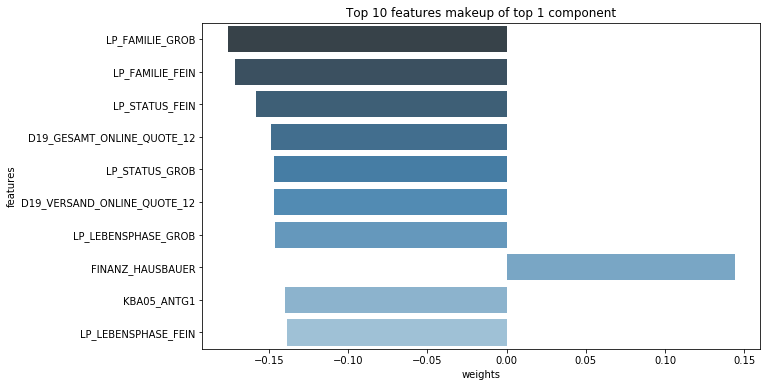

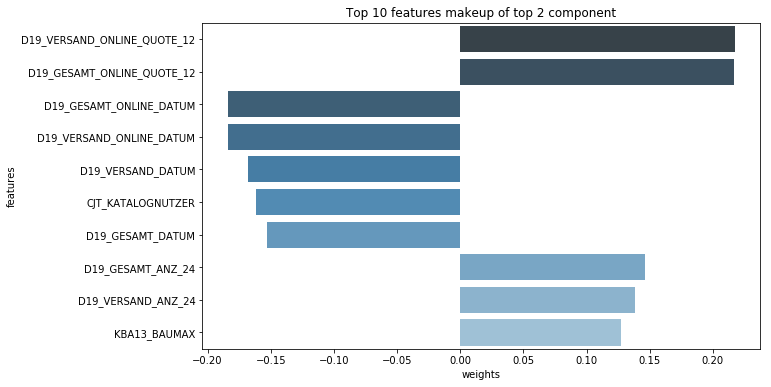

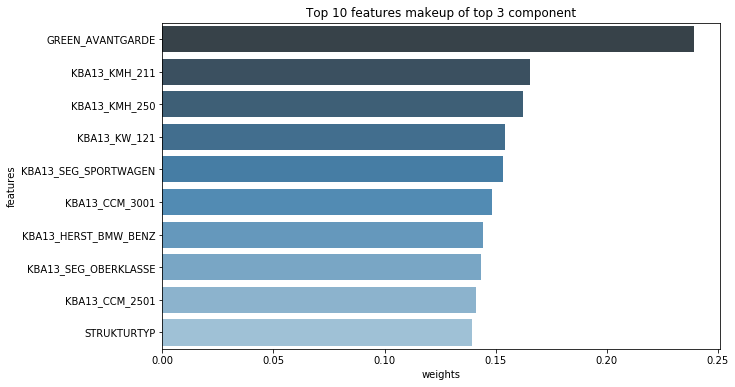

In [26]:
selected_components = ['top 1 component', 'top 2 component', 'top 3 component']
plot_components_makeup(0, selected_components, 10, weights_df)

<font color=black size=4 face=雅黑>2. K-Mean Clustering</font>

After De-demensionalize the features of customers to 149 main components, we implement unsupervised learning method--K-Mean clustering to generate labels that can represent characteristics of company's customers. By analysing features with a higher weights in these labels, we can get some original columns that are significant when determining a potential customer.

<font color=black size=4 face=雅黑>Choosing a suitable K</font>

We decide the number of centroids by plotting elbow graph and selecting K where the centroid distance comes with an elbow.

In [27]:
distortions = []
K = range(1, 25)
for k in K:                       #get inertia of models with 1-30 clusters 
    kmean_model = KMeans(n_clusters = k)
    kmean_model.fit(pc_values)
    distortions.append(kmean_model.inertia_)
    print('model with {} cluster(s) has been finished!'.format(k))

model with 1 cluster(s) has been finished!
model with 2 cluster(s) has been finished!
model with 3 cluster(s) has been finished!
model with 4 cluster(s) has been finished!
model with 5 cluster(s) has been finished!
model with 6 cluster(s) has been finished!
model with 7 cluster(s) has been finished!
model with 8 cluster(s) has been finished!
model with 9 cluster(s) has been finished!
model with 10 cluster(s) has been finished!
model with 11 cluster(s) has been finished!
model with 12 cluster(s) has been finished!
model with 13 cluster(s) has been finished!
model with 14 cluster(s) has been finished!
model with 15 cluster(s) has been finished!
model with 16 cluster(s) has been finished!
model with 17 cluster(s) has been finished!
model with 18 cluster(s) has been finished!
model with 19 cluster(s) has been finished!
model with 20 cluster(s) has been finished!
model with 21 cluster(s) has been finished!
model with 22 cluster(s) has been finished!
model with 23 cluster(s) has been finishe

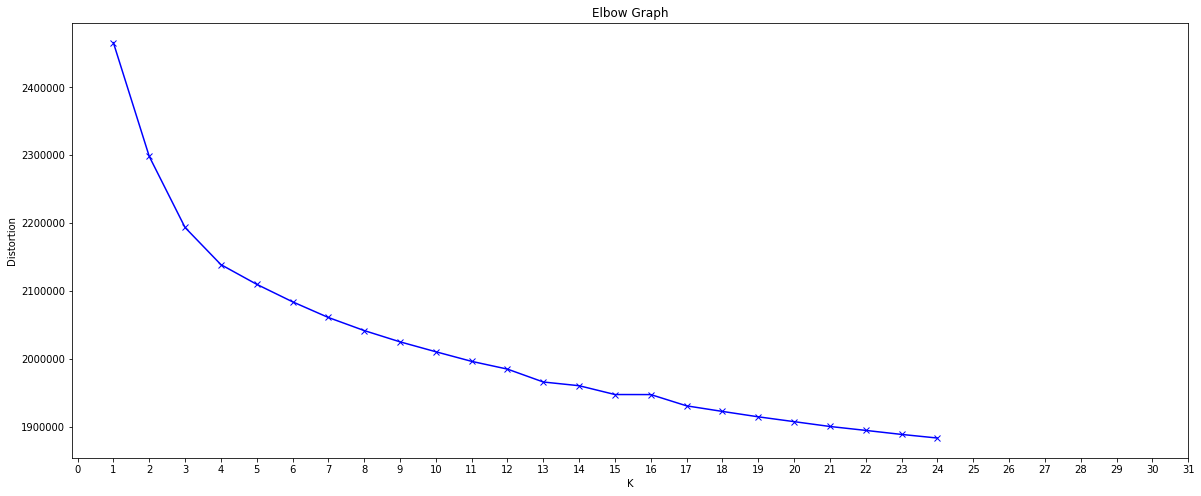

In [28]:
plt.figure(figsize = (20, 8))   #plot the elbow graph
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Elbow Graph')
x_ticks = np.arange(0, 32, 1)
plt.xticks(x_ticks)
plt.show()

We can see that 'Elbow' occurs when the clsuters number reaches 20, so we choose n_clusters as number 20.

In [29]:
model = KMeans(n_clusters = 20)     #delpoy K-Mean clustering with 20 centroids
model.fit(pc_values)
kmean_values = model.predict(pc_values)
print('shape of kmean values:{}'.format(kmean_values.shape))
print('kmean values:\n{}'.format(kmean_values))

shape of kmean values:(118929,)
kmean values:
[ 2  1 17 ..., 13 17  3]


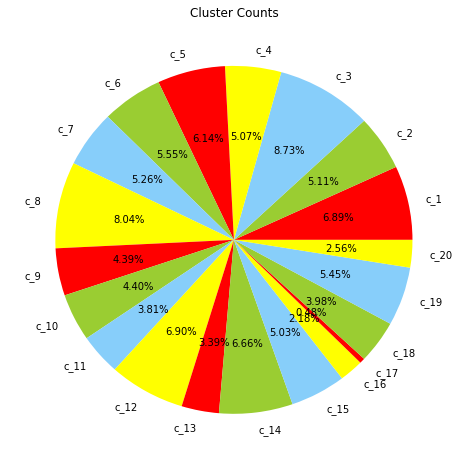

In [30]:
clusters = np.unique(kmean_values)
clusters.sort()
clusters = clusters.tolist()
clusters_list = ['c_{}'.format(cluster + 1) for cluster in clusters]    #define name of 20 clusters in a list
count_list = [kmean_values[kmean_values == i].shape[0] for i in clusters]  #get count of 20 clusters in a list
colors = ['red','yellowgreen','lightskyblue','yellow'] 

#see total number of examples in each cluster in a pie graph
plt.figure(figsize=(8,8))
explode = (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
plt.pie(count_list, explode = explode, labels = clusters_list, colors = colors, autopct = '%3.2f%%')
plt.title('Cluster Counts')
plt.show()

In [31]:
#get weights dataframe
kmean_weights = model.cluster_centers_
kmean_weights_df = pd.DataFrame(kmean_weights)
kmean_weights_df.columns = components_list
kmean_weights_df.index = clusters_list
kmean_weights_df

,top 1 component,top 2 component,top 3 component,top 4 component,top 5 component,top 6 component,top 7 component,top 8 component,top 9 component,top 10 component,...,top 140 component,top 141 component,top 142 component,top 143 component,top 144 component,top 145 component,top 146 component,top 147 component,top 148 component,top 149 component
c_1,-2.080434,0.460965,-1.100898,0.171167,0.054306,0.458056,-0.121413,0.207637,-0.191143,0.103852,...,0.002202,0.001397,0.013392,-0.007750,0.008224,0.004641,-0.002688,0.002279,-0.008833,0.000506
c_2,1.907856,-0.021189,-0.639406,0.710904,-0.677235,0.093883,0.002299,-0.148786,-0.038895,0.216183,...,0.011456,0.007467,0.001309,-0.017222,0.009711,0.004259,-0.004794,-0.001683,0.000229,-0.000592
c_3,0.449441,-1.239633,0.475465,-0.307808,0.297596,-0.362695,-0.351821,-0.050878,0.349459,-0.150638,...,-0.000624,0.003112,-0.009259,0.000570,0.003883,0.000472,-0.005040,0.006573,0.000343,-0.003830
c_4,-0.813718,-1.033072,-0.935550,-0.008181,0.168866,0.353983,0.764817,0.101991,-0.410284,0.115630,...,0.013637,0.008541,-0.008811,0.003803,-0.005596,0.005293,0.003978,-0.006973,-0.007408,0.009499
c_5,0.451603,-0.776052,0.210404,0.618038,-0.993705,-0.512483,0.285903,-0.275656,0.025791,-0.196050,...,-0.003081,0.008548,0.006839,-0.006545,0.008099,0.004312,0.014706,-0.008650,0.005223,-0.005354
c_6,-0.338242,-0.169839,2.242658,0.228681,0.043810,0.107511,-0.036597,0.048688,0.011185,0.132321,...,0.008673,-0.008015,-0.004537,0.000070,-0.013554,0.008724,-0.003779,-0.000846,-0.006869,0.006763
c_7,-1.103191,0.933193,0.111507,0.685659,-1.026070,-0.331461,0.046349,-0.243503,-0.112735,-0.141710,...,-0.013150,-0.008194,-0.005718,-0.007457,-0.009031,-0.018940,0.003592,-0.009516,0.004237,0.004193
c_8,-1.630131,0.767524,0.591235,-0.456986,0.102759,-0.182244,-0.225014,-0.031831,-0.179503,-0.055526,...,-0.011935,-0.001404,0.004861,-0.002936,0.011356,0.017535,-0.007904,0.007124,0.004691,0.005933
c_9,-1.273460,-0.171787,0.039698,-0.727793,-0.261063,0.308519,0.717624,0.020999,0.533894,0.041020,...,0.002376,0.001645,-0.000660,0.013900,0.001766,-0.004360,0.006687,0.007860,-0.003407,-0.007175
c_10,-0.883904,1.016035,-0.448261,1.044248,1.002289,-0.529928,0.278154,-0.063101,0.312410,0.067491,...,0.017821,-0.006717,0.001634,0.025717,-0.001574,-0.015525,0.006326,-0.014181,0.010898,-0.018187


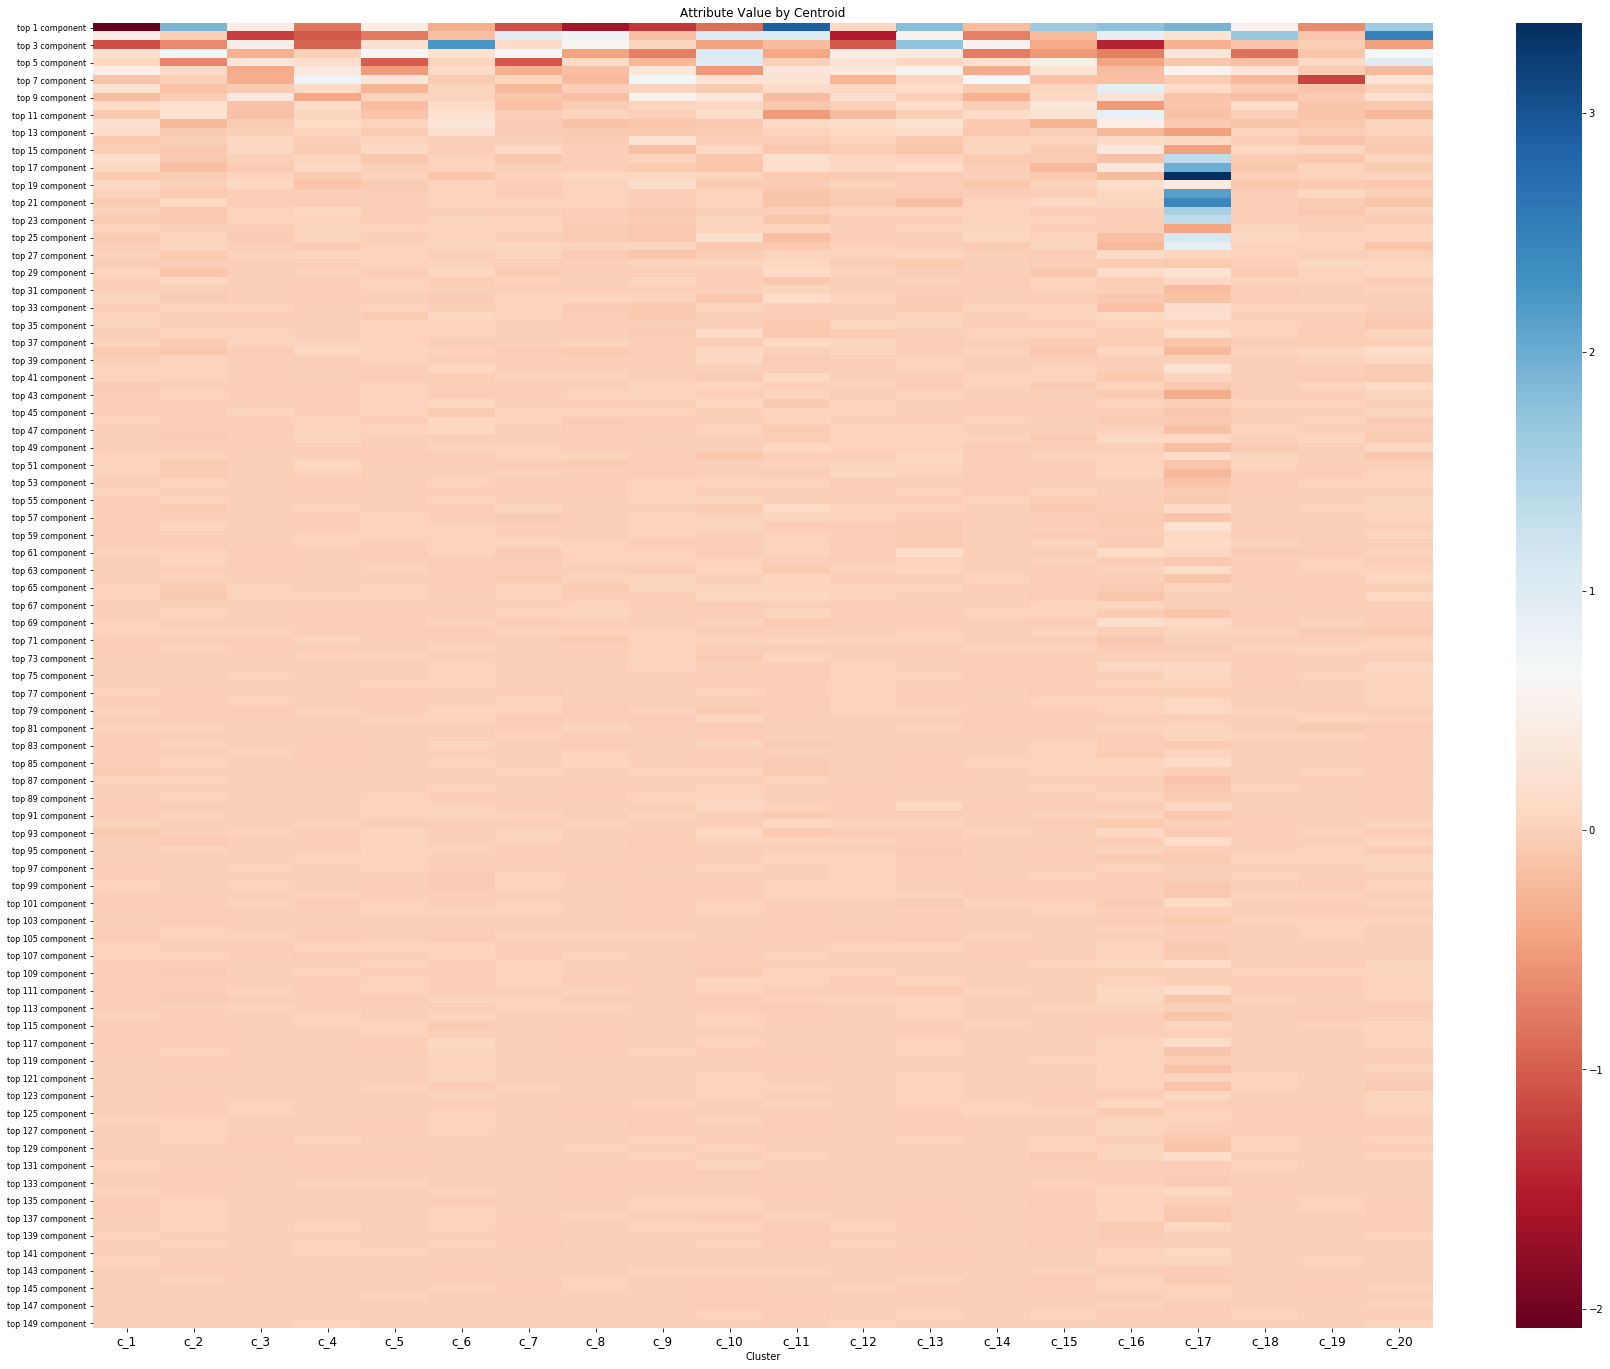

In [32]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (30, 24))
ax = sns.heatmap(kmean_weights_df.T, cmap = 'RdBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 12)
ax.set_title("Attribute Value by Centroid")
plt.show()

We can see that normally top 30 components in each cluster have deeper colors, indicating they are more significant to determine which cluster an example belongs to.

<font color=black size=4 face=雅黑>3. Analyse Original Features Weights of Clusters</font>

By multiplying kmean_weights and pc_weights metrics, we can get weights of original features in each cluster generated by 20-number K-Means. This gives us the insights of which features show greater significance, quantified as weights, in customers group.

In [33]:
features_weights_df = pd.DataFrame(kmean_weights.dot(pc_weights))   #get features weights DataFrame
features_weights_df.columns = customers_values.columns
features_weights_df.index = clusters_list
features_weights_df

features,KBA13_CCM_2501,VK_ZG11,D19_BIO_OEKO,KBA13_BJ_2008,KBA13_ALTERHALTER_61,AKT_DAT_KL,D19_VERSI_DATUM,D19_VERSI_ONLINE_QUOTE_12,KBA05_HERSTTEMP,INNENSTADT,...,KBA05_SEG3,CJT_TYP_5,D19_SONSTIGE,LP_STATUS_FEIN,KBA13_SEG_OBERKLASSE,D19_VERSAND_DATUM,SHOPPER_TYP,D19_BANKEN_ONLINE_DATUM,UNGLEICHENN_FLAG,D19_BANKEN_ANZ_12
c_1,-0.099415,-0.037145,0.082918,-0.071729,-0.242435,-0.037044,-0.142229,0.002858,-0.000697,0.215201,...,0.019521,-0.031463,0.032238,0.141659,-0.166454,-0.354475,-0.010700,-0.069373,0.010990,0.028413
c_2,-0.033560,0.157748,-0.049310,-0.028052,0.073213,0.048863,0.085515,-0.001458,0.007341,-0.035018,...,0.014632,0.008076,-0.117913,-0.503018,-0.012020,0.220578,0.044708,0.044973,-0.043107,-0.017500
c_3,0.009975,-0.001583,-0.059715,0.040213,0.063217,-0.026421,0.059252,-0.001452,-0.008806,-0.012698,...,-0.016592,0.105607,0.016781,0.217879,0.024203,0.244773,-0.028831,0.047084,-0.054526,-0.018241
c_4,-0.078118,-0.020737,-0.024512,-0.066005,-0.211254,-0.022964,-0.025075,-0.000489,-0.000269,0.215367,...,0.011847,0.040064,0.031941,0.138205,-0.144889,0.170839,-0.017741,0.028153,0.050558,-0.008955
c_5,0.018005,-0.001624,-0.026726,0.038212,0.071540,-0.005403,0.059341,-0.001420,-0.009491,-0.014726,...,-0.014739,0.079539,0.022410,0.203697,0.029587,0.199922,0.059405,0.046245,-0.015230,-0.017305
c_6,0.373233,-0.084558,0.004569,0.187008,0.267627,-0.017092,-0.008170,0.000491,-0.040915,-0.121767,...,-0.050532,0.065426,0.052001,0.155344,0.351637,-0.046920,0.027892,-0.011838,0.010789,0.006155
c_7,0.012637,-0.056531,0.062067,0.029766,0.033808,-0.016844,-0.066718,0.001669,0.000282,0.018652,...,-0.012898,-0.035367,0.033865,0.159197,0.013178,-0.324920,0.129219,-0.062746,0.042856,0.025803
c_8,0.016437,-0.078004,0.066230,0.047060,0.035303,-0.029006,-0.071014,0.001937,-0.006844,-0.010651,...,-0.023588,-0.010827,0.029250,0.206947,0.026978,-0.363438,-0.038308,-0.073851,0.014739,0.030528
c_9,-0.027673,-0.115838,0.241309,-0.014072,-0.053378,-0.029339,-0.080334,0.000743,-0.002980,0.108524,...,-0.008682,0.037678,0.121947,0.183192,-0.055647,0.003709,-0.014109,-0.008767,0.008704,0.007265
c_10,-0.014235,0.112371,-0.008068,-0.002281,-0.030811,0.106432,-0.070860,0.001444,0.007141,0.071443,...,-0.006099,-0.466801,-0.097370,0.004821,-0.027725,-0.189027,-0.065929,-0.059195,0.093416,0.018195


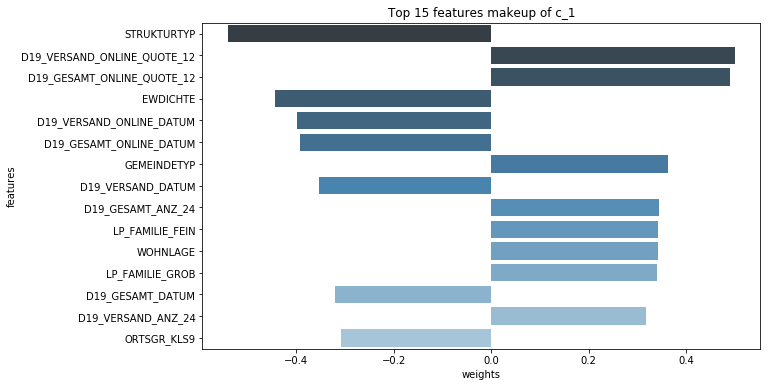

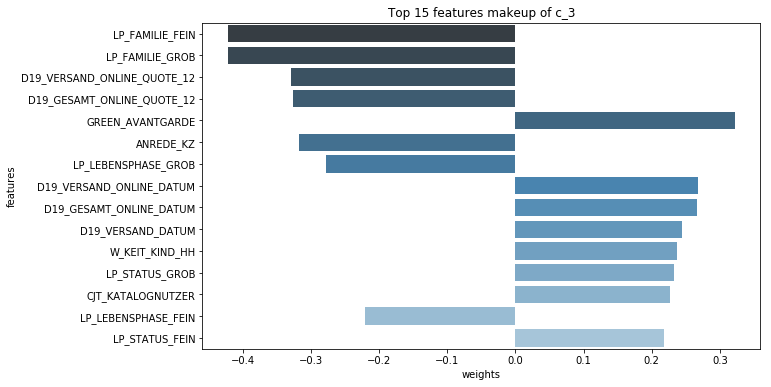

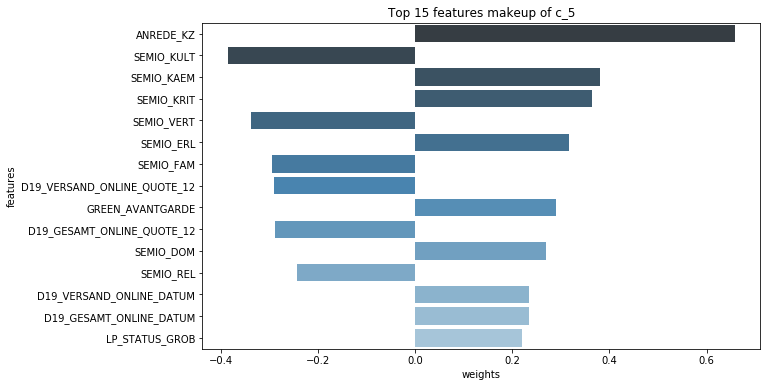

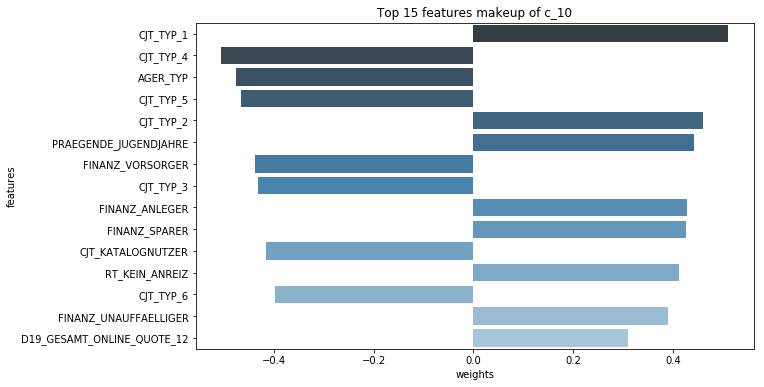

In [34]:
#visualize top n makeup features in some clusters
clusters_list = ['c_1', 'c_3', 'c_5', 'c_10']
plot_components_makeup(0, clusters_list, 15, features_weights_df)

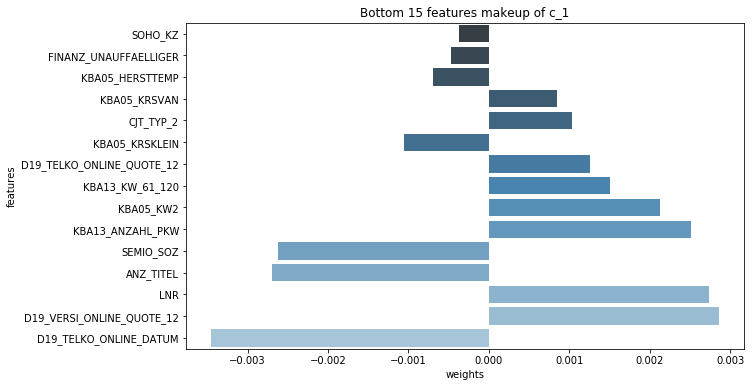

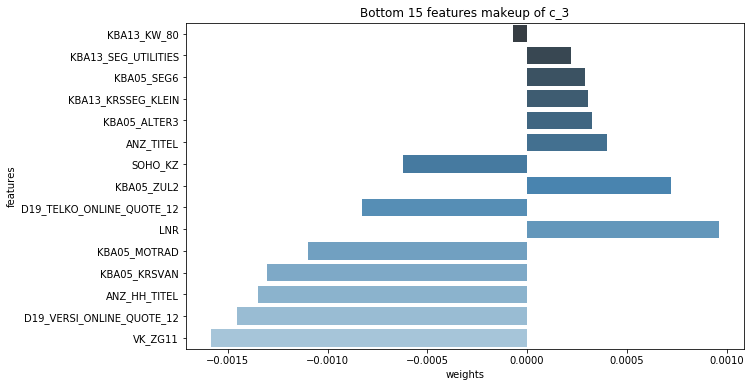

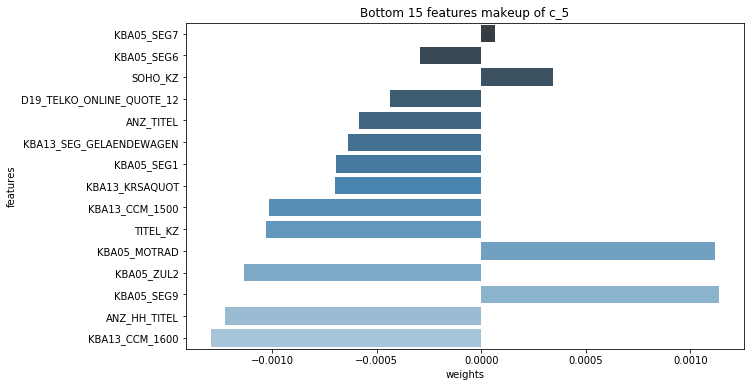

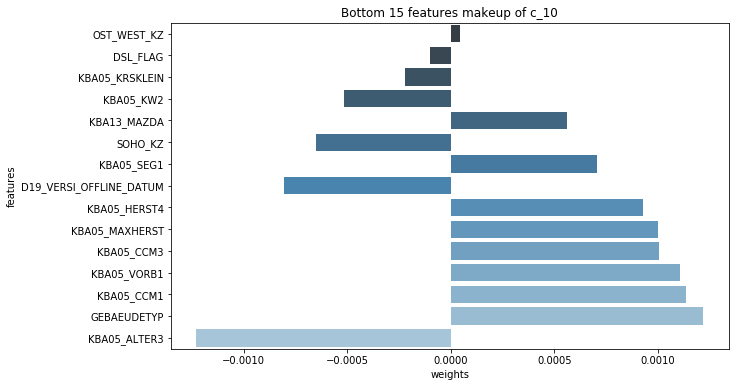

In [35]:
#visualize bottom n makeup features in each cluster
plot_components_makeup(1, clusters_list, 15, features_weights_df)

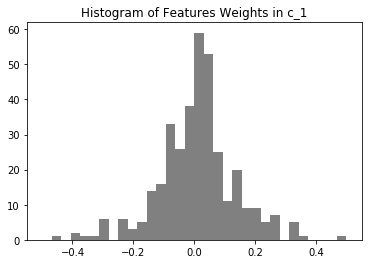

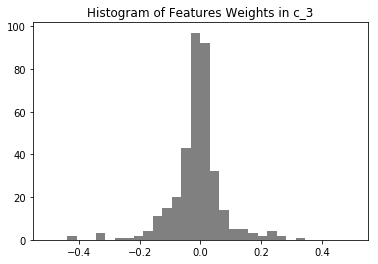

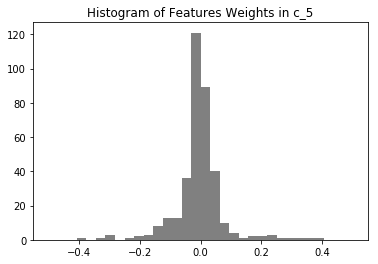

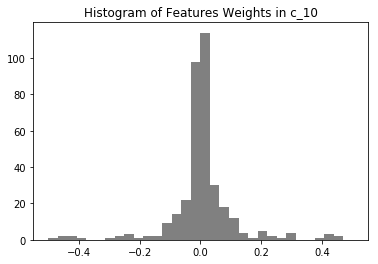

In [36]:
#plot histograms of the distribution of features weights in clusters
for cluster in clusters_list:
    ax = plt.subplots(figsize=(6,4))
    ax = plt.hist(features_weights_df.loc[cluster,:].tolist(), bins=32,  range=(-0.5, 0.5), color='gray', rwidth=1)
    title="Histogram of Features Weights in {}".format(cluster)
    plt.title(title, fontsize=12)
    plt.show()


After visualizing weights in different plotting methods, we can draw a conclusion that:

- The distribution of features weights in each cluster is close to the Normal Distribution with 0 avergae by watching the histograms. The further one feature's weight is from the average, the more significant this feature will be.
- We can rank the importance of features by sorting their weights-- we get the absolute weights in each column, and sum them up to make them comparable. The features whose total absolute weights are less than 0.5 and every signal weight are less than 0.03 are defined as insignificant features. We can see there are 16 insignificant features by calculating.

Finally we get a sorted features series with 359 labels.

In [37]:
#rank the importance of features
features_df = features_weights_df.apply(lambda x:abs(x).sum(), axis = 0)
features_df = features_df.sort_values(ascending = False)
features_df = features_df.reset_index(name = 'ABS_SUM_WEIGHTS')

#get insignificant features
bad_features1 = features_df[features_df['ABS_SUM_WEIGHTS'] <= 0.5].copy()
bad_list1 = bad_features1['features'].tolist()
bad_features2 = features_weights_df.apply(lambda x:(abs(x) <= 0.03).mean(), axis = 0)
bad_list2 = bad_features2[bad_features2 == 1.0].index.tolist()
bad_features = list(set(bad_list1).intersection(bad_list2))
bad_df = features_df[features_df['features'].isin(bad_features)].copy()
bad_index = bad_df.index

features_df.loc[bad_index, 'ABS_SUM_WEIGHTS'] = 'INSIGNIFICANT'
features_df

,features,ABS_SUM_WEIGHTS
0,D19_GESAMT_ONLINE_QUOTE_12,5.93123
1,D19_VERSAND_ONLINE_QUOTE_12,5.85895
2,GREEN_AVANTGARDE,5.84585
3,LP_FAMILIE_GROB,5.84335
4,LP_FAMILIE_FEIN,5.69701
5,LP_STATUS_FEIN,5.54125
6,LP_STATUS_GROB,5.25916
7,ANREDE_KZ,5.15898
8,KBA05_ANTG1,4.94651
9,LP_LEBENSPHASE_GROB,4.657


Our result is valid because it makes sense in two aspects:

- First, the most important features, like 'LP_STATUS_FEIN' as well as 'GREEN_AVANTGARDE', are top components of some clusters. It reveals that our calculation is correct and we successfully rank the significance of our features by their weights in K-Mean clusters.
- Second, it just makes sense intuitively, too. For instance, label 'GREEN_AVANTGARDE' is to value the extent of a green consumer, and it is a good indicator to judge a buyer's status. Whether a person is a green consumer or not can greatly effect his purchasing habits, then can help to predict his possibility of be a customer of the company. On the contrary, feature like 'NATIONALITAET' with a low weights is less likely to be a good predictor, since people in every nation buy materials and get services locally or online in our modern society.

<font color=black size=4 face=雅黑>4. Rebuild Model in Azdias and Find Insights</font>

The last section of our unsupervised learning is to predict the classes of customers:

- Rebuild a K-Mean model in azdias and utilize the predictions of customers to compare the distribution of each cluster we generate in two dataset, and then find insights in the original features.

<font color=black size=3 face=雅黑>Rebuild K-Means:</font>

In [39]:
#PCA
azdias_values = azdias_scaled.values
pca = PCA()
pca_metrics = pca.fit_transform(azdias_values)
pca_ratio = pca.explained_variance_ratio_

print(pca_metrics)
print(pca_ratio)

[[  4.87959142e-01  -2.00395914e-01  -5.71392561e-02 ...,  -2.37060829e-03
    3.40671528e-03  -6.49023866e-17]
 [ -7.15585606e-01   1.69131433e+00   1.59415160e+00 ...,  -4.69637950e-04
   -1.08632268e-04   3.10776536e-16]
 [ -2.21514057e-01  -7.77740988e-01  -8.54227372e-02 ...,  -1.56220626e-03
    4.15568674e-03  -1.53794843e-16]
 ..., 
 [  2.88464879e+00   5.82488277e-01  -6.79195251e-01 ...,  -1.86954780e-03
   -1.35963124e-03   6.86225819e-18]
 [  3.26196107e+00  -1.83915489e-01   8.82322042e-02 ...,   5.27309775e-04
   -2.54572649e-03   1.25189391e-17]
 [  2.60027426e+00   8.46344915e-01  -1.45816248e+00 ...,   8.03866113e-04
    1.26888041e-03  -5.46345900e-18]]
[  1.01193830e-01   7.52349392e-02   4.79474552e-02   4.64924697e-02
   3.24319065e-02   2.33992829e-02   2.21183171e-02   1.80046617e-02
   1.59002861e-02   1.52344131e-02   1.35920788e-02   1.21679134e-02
   1.13712622e-02   1.04232852e-02   1.01966744e-02   9.11756482e-03
   8.75215361e-03   8.34400381e-03   8.04811

In [40]:
#get 90% main components
pca_ratio_cumsum = pca_ratio.cumsum()
n = len(pca_ratio_cumsum[pca_ratio_cumsum <= 0.9])
print('{} main components'.format(n))

145 main components


In [19]:
#PCA with 145 components
pca_n = PCA(n_components = n)
pca_metrics = pca_n.fit_transform(azdias_values)
pca_weights = pca_n.components_

print(pca_weights)

[[ -1.03703204e-01  -4.77396323e-02  -9.34981898e-02 ...,   1.28293711e-02
   -3.23210767e-02  -6.80679207e-02]
 [ -1.46137376e-02   2.48438011e-05  -1.25719012e-02 ...,  -1.28513725e-01
    8.76861734e-02   1.15430244e-01]
 [ -7.66783166e-02   2.44297717e-02  -1.05935888e-02 ...,   6.43686888e-02
    1.78716746e-02   6.84671811e-02]
 ..., 
 [ -1.96780549e-02   1.30477558e-02   2.12238970e-03 ...,   3.34256865e-02
   -1.08801766e-02  -1.18313645e-01]
 [  3.88013478e-02  -4.93151550e-02   2.09238415e-02 ...,   1.25070467e-02
   -2.18418697e-03  -7.25976547e-02]
 [  5.07584962e-03  -6.87763360e-03   1.05697741e-03 ...,  -2.49788101e-02
    2.45388798e-03  -5.13170866e-02]]


In [20]:
#find suitable k
distortions = []
K = range(1, 20)
for k in K:                      
    kmean_model = KMeans(n_clusters = k)
    kmean_model.fit(pca_metrics)
    distortions.append(kmean_model.inertia_)
    print('model with {} cluster(s) has been finished!'.format(k))

model with 1 cluster(s) has been finished!
model with 2 cluster(s) has been finished!
model with 3 cluster(s) has been finished!
model with 4 cluster(s) has been finished!
model with 5 cluster(s) has been finished!
model with 6 cluster(s) has been finished!
model with 7 cluster(s) has been finished!
model with 8 cluster(s) has been finished!
model with 9 cluster(s) has been finished!
model with 10 cluster(s) has been finished!
model with 11 cluster(s) has been finished!
model with 12 cluster(s) has been finished!
model with 13 cluster(s) has been finished!
model with 14 cluster(s) has been finished!
model with 15 cluster(s) has been finished!
model with 16 cluster(s) has been finished!
model with 17 cluster(s) has been finished!
model with 18 cluster(s) has been finished!
model with 19 cluster(s) has been finished!


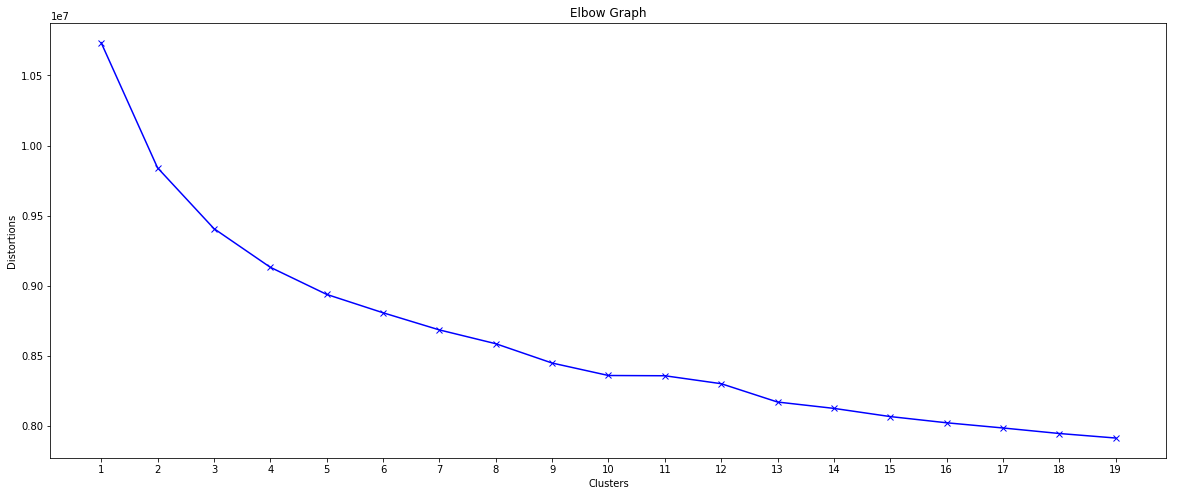

In [22]:
plt.figure(figsize = (20,8))
plt.plot(K, distortions, 'bx-')
plt.title('Elbow Graph')
plt.xlabel('Clusters')
plt.ylabel('Distortions')
plt.xticks(np.arange(1, 20, 1))
plt.show()

We choose 13 as our total number of clusters

In [23]:
model = KMeans(n_clusters = 13)   #get predictions of azdias and segmentation
model.fit(pca_metrics)
azdias_predictions = model.predict(pca_metrics)

clusters = np.unique(azdias_predictions)
clusters.sort()
clusters = clusters.tolist()
clusters_list = ['c_{}'.format(i + 1) for i in clusters]

seg_azdias = [(azdias_predictions == i).mean() for i in clusters]

In [24]:
customers_values = customers_scaled.iloc[:,:-3].values   #predict customers labels
pca_metrics1 = customers_values.dot(pca_weights.T)
print('shape of pca_customers:{}'.format(pca_metrics1.shape))

customers_predictions = model.predict(pca_metrics1)
seg_customers = [(customers_predictions == i).mean() for i in clusters]

shape of pca_customers:(118929, 145)


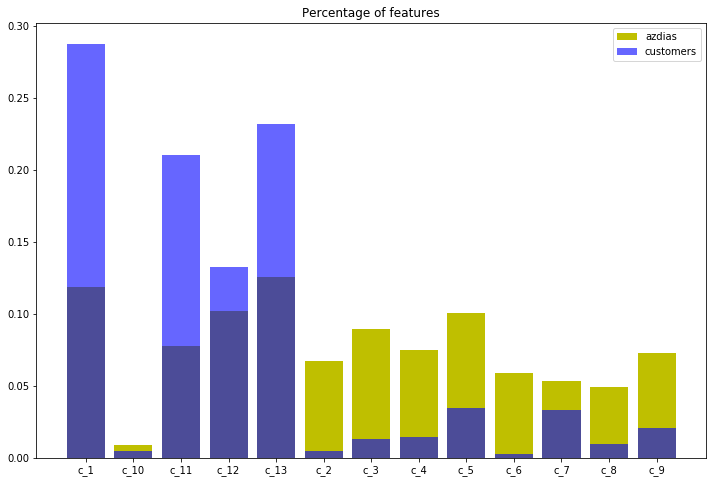

In [25]:
plt.figure(figsize = (12, 8))   #plot segmentation of two dataset
plt.bar(clusters_list, seg_azdias, color = 'y', label = 'azdias')
plt.bar(clusters_list, seg_customers, color = 'b', label = 'customers', alpha = 0.6)
plt.title('Percentage of features')
plt.legend()

We can see clearly that customers gather in four clusters--c_1, c_11, c_12, c_13, and the most profound difference is in group c_1 and c_11. So the top features in these two clusters are importance to determine whether a person will be a customer.

Our next job is to get original features weights in each cluster and find exciting patterns of features in customers. 

In [27]:
kmean_weights = model.cluster_centers_
features_weights_df = pd.DataFrame(kmean_weights.dot(pca_weights))
features_weights_df.index = ['c_{}'.format(i + 1) for i in range(13)]
features_weights_df.columns = azdias_scaled.columns
features_weights_df

,KBA13_AUTOQUOTE,KBA13_SEG_GROSSRAUMVANS,KBA13_GBZ,D19_KONSUMTYP,KBA13_PEUGEOT,D19_LEBENSMITTEL,EWDICHTE,KBA05_CCM4,D19_TECHNIK,KBA13_BMW,...,CJT_TYP_4,KBA13_BJ_2008,KBA13_CCM_1500,KBA13_ALTERHALTER_61,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HHZ,RETOURTYP_BK_S,D19_VERSAND_REST,D19_VERSAND_ANZ_24
c_1,0.147622,0.097804,0.131919,-0.336701,-0.020052,0.087141,-0.182697,0.001037,0.222403,-0.003782,...,0.128758,0.009569,0.022681,-0.041447,0.384474,0.006848,-0.018844,-0.016038,0.123748,0.257419
c_2,-0.269258,-0.133817,-0.291845,0.300502,0.030118,-0.041761,0.302672,-0.047250,-0.160897,-0.060443,...,-0.268683,-0.115753,-0.030647,-0.027261,-0.291390,-0.012233,0.027049,-0.156668,-0.027903,-0.175775
c_3,-0.159206,-0.050741,-0.154871,-0.290942,0.009556,0.018896,0.242689,-0.026594,-0.027716,0.014046,...,-0.229752,-0.055515,-0.025838,0.042967,0.526796,-0.002194,0.039114,-0.158999,0.154177,0.269065
c_4,0.070532,0.074845,0.114305,0.278831,-0.004906,-0.047258,-0.068369,-0.005639,-0.119879,0.021149,...,-0.237858,0.022080,0.009539,0.019189,-0.284094,0.002719,0.018514,-0.205135,-0.030484,-0.165411
c_5,0.138499,0.103922,0.141051,-0.333815,-0.022978,0.063425,-0.167103,0.010183,0.150095,0.010234,...,-0.270914,0.027568,0.025048,-0.027272,0.453529,0.006237,-0.012578,-0.216217,0.194181,0.288491
c_6,0.169696,-0.247867,-0.015404,-0.119689,0.007100,0.014060,-0.416892,-0.071098,0.054989,-0.286433,...,0.023071,-0.042327,0.079581,-0.252598,0.076432,0.007082,-0.202407,-0.030886,0.020059,0.053925
c_7,-0.349538,-0.123737,-0.294826,0.114483,0.057163,-0.031244,0.403537,0.044381,-0.065996,0.228362,...,-0.067216,-0.004556,-0.076899,-0.084075,-0.131156,-0.021433,0.090461,0.139771,-0.064133,-0.094253
c_8,-0.196947,-0.265275,-0.269147,0.124391,0.071657,-0.027266,0.093045,-0.095729,-0.048487,-0.239359,...,0.231553,0.012470,0.027778,0.013014,-0.150320,0.010129,-0.000084,0.201557,-0.103914,-0.103856
c_9,0.060092,0.069988,0.114529,0.206925,-0.005120,-0.038563,-0.062960,-0.005714,-0.072133,0.018370,...,-0.255021,0.012713,0.009263,0.020489,-0.249078,0.005152,0.027264,-0.153472,-0.043018,-0.159669
c_10,-0.139753,-0.105049,-0.127556,0.165584,0.021903,-0.028240,0.084465,0.862167,-0.129462,-0.018247,...,0.032713,-0.068943,0.007975,-0.097034,-0.118281,0.003553,0.031540,0.102246,-0.046758,-0.091531


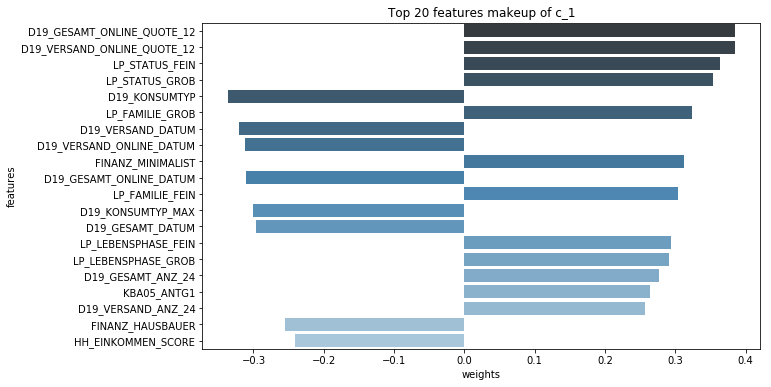

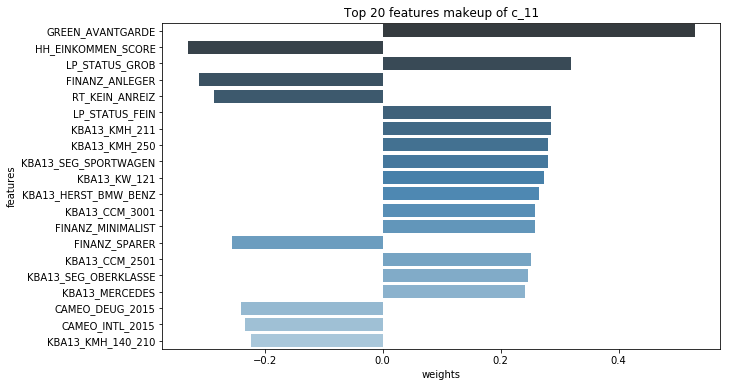

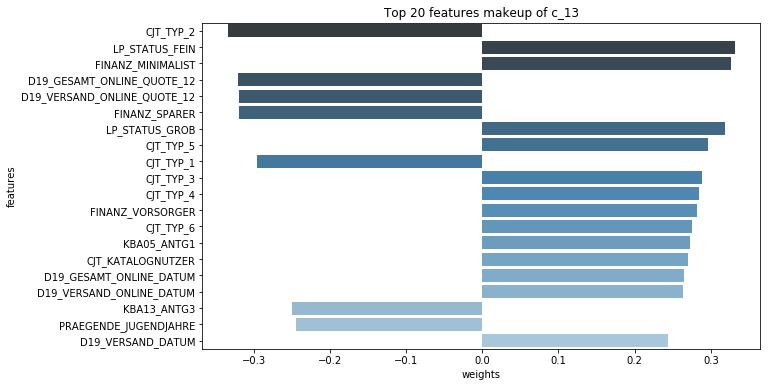

In [30]:
plot_components_makeup(0, ['c_1','c_11','c_13'], 20, features_weights_df)

Judging from the features weights in c_1, c_11 and c_13 clusters, we can draw some conclusions that:

- A person who is a green consumer, matching the high positive weight of 'GREEN_AVANTGARDE' tends to be a customer of the company. 
- People who have vehicles of BMW and BENZ are easy to be customers of the company because there is a big positive weight of 'KBA13_HERST_BMW_BENZ' in cluster 11th.
- People who are inclined to minimalist are potential customers, due to the fact that 'FINANZ_MINIMALIST' has a high positive weight in cluster first and 13th.

- From 'FINANZ_VORSORGER' and 'FINANZ_SPARER' we can conclude that a person who takes care of his financial situation advancedly will less likely be a customer. 

**Finally, it seems that people with higher income and better living quality are more inclined to be customers of Arvato and respond to the mailout campaign, because they can better manage their money. And those who take their daily expenses into greater account are not potential customers of the company at all.**

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [31]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In this section, I will conduct two attempts to build a ML model and compare their performance:

- the benchmark model: I will simply build logistic regression model as the benchmark, my final model is going to outperform the benchmark.
- my first attempt is to put all valid features I get in former section into the model and implement a XGBoost model to predict whether a person is a potential consumer, after splitting the data randomly into training set and validation set.
- Notice that I have sorted a series of importance features in unsupervised learning method before, I will filter features by their rank and implement a XGBoost model again. 

By conducting hyperparameters tunning and comparing AUC-ROC performance in these three models, I will get my final model!

<font color=black size=4 face=雅黑>1. Preprocess Data</font>

The procedure of processing data is similar with our former work--drop the same columns of data, transform uncomputable columns into numbers with the same methods, tansform all values into float32 type and normalize data with MaxMinScaler.

In [40]:
#drop NAN and columns
features_left = list(azdias_scaled.columns)
features_left.append('RESPONSE')

mailout_df = mailout_train[features_left].copy()
mailout_df = mailout_df.dropna(axis = 0)
mailout_df = mailout_df.reset_index(drop = True)
mailout_df.head()

,KBA13_HERST_EUROPA,SEMIO_REL,KBA05_KRSOBER,ANREDE_KZ,D19_BIO_OEKO,KBA13_SEG_KLEINWAGEN,KBA05_ALTER1,KBA05_CCM3,KBA13_CCM_1600,KBA13_CCM_3000,...,KBA13_KW_80,KBA13_PEUGEOT,D19_VERSAND_OFFLINE_DATUM,CJT_KATALOGNUTZER,AGER_TYP,TITEL_KZ,KBA05_CCM1,KBA13_KRSAQUOT,KBA13_KW_0_60,RESPONSE
0,5.0,1,2.0,2,0,2.0,1.0,2.0,4.0,3.0,...,3.0,4.0,9,5.0,2,0.0,1.0,2.0,2.0,0
1,2.0,3,1.0,2,0,3.0,3.0,3.0,2.0,2.0,...,4.0,3.0,5,2.0,1,0.0,3.0,4.0,3.0,0
2,2.0,2,2.0,2,0,1.0,2.0,2.0,3.0,5.0,...,2.0,3.0,10,5.0,2,0.0,3.0,4.0,2.0,0
3,3.0,4,2.0,1,0,2.0,1.0,4.0,2.0,4.0,...,5.0,4.0,7,5.0,2,0.0,2.0,3.0,1.0,0
4,4.0,3,3.0,2,0,4.0,3.0,5.0,3.0,3.0,...,2.0,4.0,4,3.0,3,0.0,4.0,1.0,5.0,0


In [41]:
#transform object columns
str_columns_train = get_str_columns(mailout_df)   
print('Values in mailout_train columns should be numeralized:{}'.format(str_columns_train))

mailout_ = delet_str(mailout_df, str_columns_train)
mailout_ = mailout_.dropna()
print('Shape of mialout_:{}'.format(mailout_.shape))
print('All of the columns in mailout are numeral:{}'.format((len(get_str_columns(mailout_)) == 0)))

Values in mailout_train columns should be numeralized:['CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
CAMEO_INTL_2015 colunm has been finished
D19_LETZTER_KAUF_BRANCHE colunm has been finished
OST_WEST_KZ colunm has been finished
CAMEO_DEU_2015 colunm has been finished
CAMEO_DEUG_2015 colunm has been finished
Shape of mialout_:(29376, 360)
All of the columns in mailout are numeral:True


In [44]:
#compress and scale the data
mailout_compressed = compress_data(mailout_)

scaler = MinMaxScaler()
mailout_scaled = pd.DataFrame(scaler.fit_transform(mailout_compressed.astype(np.float32)))
mailout_scaled.columns = mailout_compressed.columns
mailout_scaled.index = mailout_compressed.index
mailout_scaled

,KBA13_HERST_EUROPA,SEMIO_REL,KBA05_KRSOBER,ANREDE_KZ,D19_BIO_OEKO,KBA13_SEG_KLEINWAGEN,KBA05_ALTER1,KBA05_CCM3,KBA13_CCM_1600,KBA13_CCM_3000,...,KBA13_KW_80,KBA13_PEUGEOT,D19_VERSAND_OFFLINE_DATUM,CJT_KATALOGNUTZER,AGER_TYP,TITEL_KZ,KBA05_CCM1,KBA13_KRSAQUOT,KBA13_KW_0_60,RESPONSE
0,1.00,0.000000,0.125,1.0,0.000000,0.25,0.111111,0.125,0.75,0.6,...,0.6,0.75,0.888889,1.00,0.75,0.0,0.000,0.25,0.25,0.0
1,0.25,0.333333,0.000,1.0,0.000000,0.50,0.333333,0.250,0.25,0.4,...,0.8,0.50,0.444444,0.25,0.50,0.0,0.250,0.75,0.50,0.0
2,0.25,0.166667,0.125,1.0,0.000000,0.00,0.222222,0.125,0.50,1.0,...,0.4,0.50,1.000000,1.00,0.75,0.0,0.250,0.75,0.25,0.0
3,0.50,0.500000,0.125,0.0,0.000000,0.25,0.111111,0.375,0.25,0.8,...,1.0,0.75,0.666667,1.00,0.75,0.0,0.125,0.50,0.00,0.0
4,0.75,0.333333,0.250,1.0,0.000000,0.75,0.333333,0.500,0.50,0.6,...,0.4,0.75,0.333333,0.50,1.00,0.0,0.375,0.00,1.00,0.0
5,0.75,0.166667,0.125,1.0,0.000000,0.50,0.111111,0.250,1.00,0.6,...,0.0,0.25,1.000000,0.75,0.50,0.0,0.250,0.50,0.00,0.0
6,0.25,0.166667,0.125,1.0,0.000000,0.50,0.111111,0.250,0.50,0.6,...,0.6,0.25,1.000000,0.50,0.75,0.0,0.125,0.75,0.50,0.0
7,0.25,0.333333,0.125,0.0,1.000000,0.50,0.111111,0.125,0.50,0.6,...,0.6,0.50,1.000000,1.00,0.75,0.0,0.375,0.75,0.50,0.0
8,0.25,0.166667,0.125,1.0,0.000000,0.25,0.222222,0.125,0.50,0.8,...,0.4,0.50,0.888889,0.75,0.50,0.0,0.250,0.25,0.50,0.0
9,0.75,0.333333,0.000,1.0,0.000000,0.50,0.111111,0.250,0.75,0.4,...,0.4,0.50,0.777778,1.00,0.50,0.0,0.250,0.50,0.50,0.0


<font color=black size=4 face=雅黑>2. Logistic Regression and XGBoost</font>

We build Logistic Regression and XGBoost model to predict customers respectively, after splitting our scaled metrics

<font color=black size=3 face=雅黑>Please Note:</font>

Because the models run so slowly in this VM, especial XGBoost models, I conducted the hyperparameter tunning in my local workspace with GPU. In the next I will show my code and final results of my tunning, not include the calculating process. Instead, in this workspace, I will only run the optimal parameters I have already got previously.

In [2]:
#import ML libriaries
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [14]:
X = mailout_scaled.iloc[:,:-1].values
y = mailout_scaled[['RESPONSE']].values
X_train, X_test, Y_train, Y_test = tts(X, y, test_size=0.3, random_state=2)

In [8]:
#losgistic regression
logis_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'saga', max_iter = 500)

#hyperparameter tunning with GridSearchCV
params = {'max_iter': [800, 1000, 1500],
         'penalty' : ['l1','l2'],
         'C': [0.05, 0.1, 0.2, 0.5, 1.0]
         }
gs = GridSearchCV(logis_model, params, refit=True, cv=3, scoring='roc_auc')
gs.fit(X_train ,Y_train.flatten())
Y_train_pred = gs.predict(X_train)
Y_test_pred = gs.predict(X_test)
Y_pred = gs.decision_function(X_test)

print('Best Parameters:{}'.format(gs.best_params_))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best Parameters:{'C': 0.1, 'max_iter': 800, 'penalty': 'l1'}


In [22]:
print('Accuracy of Logistic Regression in training set:{}'.format(np.mean(Y_train_pred == Y_train.flatten())))
print('Accuracy of Logistic Regression in test set:{}'.format(np.mean(Y_test_pred == Y_test.flatten())))
print('ROC_AUC Score:{}'.format(roc_auc(Y_test, Y_pred)))

Accuracy of Logistic Regression in training set:0.9869668822642611
Accuracy of Logistic Regression in test set:0.9866106887552479
ROC_AUC Score:0.7078878373505131


In [8]:
#XGBoost
xgb_reg = xgb.XGBClassifier(objective = 'binary:logistic')

'''
My hyperparamter tunning in my local workspace using XGBoost with GPU:

params = {'alpha':[3,4,5,6],
          'colsample_bytree':[0.2,0.25,0.3,0.35,0.4,0.45,0.5],
          'learning_rate':np.arange(0.1, 0.35, 0.01),
          'max_depth':[3,4,5,6],
          'n_estimators':np.arange(30, 55, 1)
}

'''
params = {'alpha': [6],
         'colsample_bytree': [0.35],
         'learning_rate': [0.3],
         'max_depth': [4],
         'n_estimators': [40]}
gs1 = GridSearchCV(xgb_reg, params, refit = True, cv = 10, scoring = 'roc_auc', 
                   verbose = 10)
gs1.fit(X_train, Y_train.flatten())

Y_train_pred = gs1.predict(X_train)
Y_test_pred = gs1.predict(X_test)
print('Best Parameters:{}'.format(gs1.best_params_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 
[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.8190841087392812, total=   4.3s
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.805582922824302, total=   4.3s
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.6898923554095968, total=   4.3s
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.8s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.7398649881408502, total=   4.4s
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.5s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.7286626528005838, total=   4.3s
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.1s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.8127703849734407, total=   4.4s
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   27.8s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.7771388934523483, total=   4.4s
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.5s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.7098187393899567, total=   4.4s
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   37.2s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.79671683663798, total=   4.4s
[CV] alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   41.9s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=40, score=0.8068203358986996, total=   4.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.7s finished


Best Parameters:{'alpha': 6, 'colsample_bytree': 0.35, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 40}


In [12]:
print('Accuracy of XGBoost in training set:{}'.format(np.mean(Y_train_pred == Y_train.flatten())))
print('Accuracy of XGBoost Regression in test set:{}'.format(np.mean(Y_test_pred == Y_test.flatten())))
print('ROC_AUC Score in training set:{}'.format(roc_auc(Y_train, gs1.predict_proba(X_train)[:,1])))
print('ROC_AUC Score in test set:{}'.format(roc_auc(Y_test, gs1.predict_proba(X_test)[:,1])))

Accuracy of XGBoost in training set:0.9869668822642611
Accuracy of XGBoost Regression in test set:0.9866106887552479
ROC_AUC Score in training set:0.952697433012322
ROC_AUC Score in test set:0.7727838909952145


The benchmark model--logistic regression has the accuracy 98.7% in training set and 98.7% in test set, and its ROC_AUC score is 70.8% in test set.
Our XGBoost model has the accuracy 98.7% in training set and 98.7% in test set, and its ROC_AUC score is 95.27% in training set and 77.28% in test set. Obviously, XGBoost outperforms and our model is effective and an score of 77.28% is a good outcome for our model.

<font color=black size=4 face=雅黑>3. XGBoost with Significant Features</font>

Again, I will conduct XGBoost learning model after filtering features by their importance we got in the former section. In this case, we will have less features to put into our model but more examples because we drop less NAN values just after deleting some columns.

In [33]:
#drop NAN and columns
features_left = list(azdias_scaled.columns)
features_left.append('RESPONSE')

mailout_df = mailout_train[features_left].copy()
mailout_df = mailout_df.drop(columns = bad_features)
mailout_df = mailout_df.dropna(axis = 0)
mailout_df = mailout_df.reset_index(drop = True)
mailout_df

,KBA13_AUTOQUOTE,KBA13_SEG_GROSSRAUMVANS,KBA13_GBZ,D19_KONSUMTYP,KBA13_PEUGEOT,D19_LEBENSMITTEL,EWDICHTE,KBA05_CCM4,D19_TECHNIK,KBA13_BMW,...,KBA13_BJ_2008,KBA13_CCM_1500,KBA13_ALTERHALTER_61,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HHZ,RETOURTYP_BK_S,D19_VERSAND_REST,D19_VERSAND_ANZ_24,RESPONSE
0,2.0,1.0,2.0,3.0,4.0,0,5.0,3.0,0,4.0,...,2.0,1.0,4.0,0.0,3.0,3.0,5.0,0,0,0
1,4.0,4.0,4.0,1.0,3.0,0,1.0,1.0,0,1.0,...,2.0,1.0,3.0,0.0,4.0,3.0,2.0,0,1,0
2,3.0,3.0,4.0,3.0,3.0,0,6.0,4.0,7,5.0,...,5.0,4.0,5.0,0.0,0.0,3.0,5.0,0,0,0
3,3.0,4.0,2.0,2.0,4.0,0,5.0,0.0,0,4.0,...,5.0,1.0,4.0,0.0,5.0,2.0,5.0,0,1,0
4,1.0,1.0,2.0,1.0,4.0,0,6.0,0.0,0,4.0,...,3.0,3.0,1.0,6.0,2.0,5.0,3.0,0,4,0
5,3.0,3.0,3.0,3.0,2.0,6,2.0,2.0,7,3.0,...,3.0,1.0,4.0,0.0,2.0,3.0,3.0,0,0,0
6,5.0,3.0,5.0,9.0,2.0,0,1.0,2.0,7,5.0,...,3.0,3.0,1.0,0.0,3.0,5.0,3.0,0,0,0
7,4.0,2.0,5.0,3.0,3.0,0,1.0,0.0,0,2.0,...,2.0,2.0,2.0,0.0,4.0,3.0,3.0,0,1,0
8,3.0,2.0,3.0,1.0,3.0,0,3.0,1.0,6,4.0,...,0.0,1.0,3.0,10.0,4.0,2.0,5.0,3,5,0
9,3.0,5.0,3.0,3.0,3.0,0,3.0,0.0,7,4.0,...,3.0,1.0,3.0,0.0,2.0,3.0,5.0,0,1,0


In [34]:
#transform object columns
str_columns_train = get_str_columns(mailout_df)   
print('Values in mailout_train columns should be numeralized:{}'.format(str_columns_train))

mailout_ = delet_str(mailout_df, str_columns_train)
mailout_ = mailout_.dropna()
print('Shape of mialout_:{}'.format(mailout_.shape))
print('All of the columns in mailout are numeral:{}'.format((len(get_str_columns(mailout_)) == 0)))

#compress and scale the data
mailout_compressed = compress_data(mailout_)

scaler = MinMaxScaler()
mailout_scaled = pd.DataFrame(scaler.fit_transform(mailout_compressed.astype(np.float32)))
mailout_scaled.columns = mailout_compressed.columns
mailout_scaled.index = mailout_compressed.index
mailout_scaled

Values in mailout_train columns should be numeralized:['OST_WEST_KZ', 'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'CAMEO_DEUG_2015']
OST_WEST_KZ colunm has been finished
CAMEO_DEU_2015 colunm has been finished
D19_LETZTER_KAUF_BRANCHE colunm has been finished
CAMEO_INTL_2015 colunm has been finished
CAMEO_DEUG_2015 colunm has been finished
Shape of mialout_:(29376, 344)
All of the columns in mailout are numeral:True


,KBA13_AUTOQUOTE,KBA13_SEG_GROSSRAUMVANS,KBA13_GBZ,D19_KONSUMTYP,KBA13_PEUGEOT,D19_LEBENSMITTEL,EWDICHTE,KBA05_CCM4,D19_TECHNIK,KBA13_BMW,...,KBA13_BJ_2008,KBA13_CCM_1500,KBA13_ALTERHALTER_61,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HHZ,RETOURTYP_BK_S,D19_VERSAND_REST,D19_VERSAND_ANZ_24,RESPONSE
0,0.25,0.00,0.25,0.250,0.75,0.000000,0.8,0.333333,0.000000,0.75,...,0.4,0.00,0.75,0.0,0.6,0.50,1.00,0.000000,0.000000,0.0
1,0.75,0.75,0.75,0.000,0.50,0.000000,0.0,0.111111,0.000000,0.00,...,0.4,0.00,0.50,0.0,0.8,0.50,0.25,0.000000,0.166667,0.0
2,0.50,0.50,0.75,0.250,0.50,0.000000,1.0,0.444444,1.000000,1.00,...,1.0,0.75,1.00,0.0,0.0,0.50,1.00,0.000000,0.000000,0.0
3,0.50,0.75,0.25,0.125,0.75,0.000000,0.8,0.000000,0.000000,0.75,...,1.0,0.00,0.75,0.0,1.0,0.25,1.00,0.000000,0.166667,0.0
4,0.00,0.00,0.25,0.000,0.75,0.000000,1.0,0.000000,0.000000,0.75,...,0.6,0.50,0.00,0.6,0.4,1.00,0.50,0.000000,0.666667,0.0
5,0.50,0.50,0.50,0.250,0.25,0.857143,0.2,0.222222,1.000000,0.50,...,0.6,0.00,0.75,0.0,0.4,0.50,0.50,0.000000,0.000000,0.0
6,1.00,0.50,1.00,1.000,0.25,0.000000,0.0,0.222222,1.000000,1.00,...,0.6,0.50,0.00,0.0,0.6,1.00,0.50,0.000000,0.000000,0.0
7,0.75,0.25,1.00,0.250,0.50,0.000000,0.0,0.000000,0.000000,0.25,...,0.4,0.25,0.25,0.0,0.8,0.50,0.50,0.000000,0.166667,0.0
8,0.50,0.25,0.50,0.000,0.50,0.000000,0.4,0.111111,0.857143,0.75,...,0.0,0.00,0.50,1.0,0.8,0.25,1.00,0.428571,0.833333,0.0
9,0.50,1.00,0.50,0.250,0.50,0.000000,0.4,0.000000,1.000000,0.75,...,0.6,0.00,0.50,0.0,0.4,0.50,1.00,0.000000,0.166667,0.0


In [6]:
X = mailout_scaled.iloc[:,:-1].values
y = mailout_scaled[['RESPONSE']].values
X_train, X_test, Y_train, Y_test = tts(X, y, test_size=0.3, random_state=2)

In [7]:
#XGBoost
xgb_reg = xgb.XGBClassifier(objective = 'binary:logistic')

'''
My hyperparamter tunning in my local workspace using XGBoost with GPU:

params = {'alpha':[3,4,5,6],
          'colsample_bytree':[0.2,0.25,0.3,0.35,0.4,0.45,0.5],
          'learning_rate':np.arange(0.1, 0.35, 0.01),
          'max_depth':[3,4,5,6],
          'n_estimators':np.arange(30, 55, 1)
}

'''
params = {'alpha': [6],
         'colsample_bytree': [0.25],
         'learning_rate': [0.25],
         'max_depth': [4],
         'n_estimators': [40]}
gs2 = GridSearchCV(xgb_reg, params, refit = True, cv = 10, scoring = 'roc_auc', 
                   verbose = 10)
gs2.fit(X_train, Y_train.flatten())

Y_train_pred = gs2.predict(X_train)
Y_test_pred = gs2.predict(X_test)
print('Best Parameters:{}'.format(gs2.best_params_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 
[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.8301404853128992, total=   3.4s
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.8242474001094691, total=   3.4s
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.682065316548075, total=   3.4s
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.7590220762634556, total=   3.4s
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.5s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.7240102171136653, total=   3.4s
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.1s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.7886570651479473, total=   3.4s
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.7s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.7909570487194932, total=   3.4s
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.3s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.6837887665881751, total=   3.4s
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   29.0s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.835462713727869, total=   3.4s
[CV] alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   32.6s remaining:    0.0s


[CV]  alpha=6, colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=40, score=0.8021571823937521, total=   3.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   36.3s finished


Best Parameters:{'alpha': 6, 'colsample_bytree': 0.25, 'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 40}


In [8]:
print('Accuracy of XGBoost in training set:{}'.format(np.mean(Y_train_pred == Y_train.flatten())))
print('Accuracy of XGBoost Regression in test set:{}'.format(np.mean(Y_test_pred == Y_test.flatten())))
print('ROC_AUC Score in training set:{}'.format(roc_auc(Y_train, gs2.predict_proba(X_train)[:,1])))
print('ROC_AUC Score in test set:{}'.format(roc_auc(Y_test, gs2.predict_proba(X_test)[:,1])))

Accuracy of XGBoost in training set:0.9869668822642611
Accuracy of XGBoost Regression in test set:0.9866106887552479
ROC_AUC Score in training set:0.936076822097936
ROC_AUC Score in test set:0.7896891843159424


After dropping some insignificant features, we get a better score! Now the ROC_AUC score in test set is 78.97%.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [30]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [37]:
features_left = list(mailout_scaled.columns)
features_left.remove('RESPONSE')

mailout_df = mailout_test[features_left].copy()
mailout_df.head()

,KBA13_AUTOQUOTE,KBA13_SEG_GROSSRAUMVANS,KBA13_GBZ,D19_KONSUMTYP,KBA13_PEUGEOT,D19_LEBENSMITTEL,EWDICHTE,KBA05_CCM4,D19_TECHNIK,KBA13_BMW,...,CJT_TYP_4,KBA13_BJ_2008,KBA13_CCM_1500,KBA13_ALTERHALTER_61,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HHZ,RETOURTYP_BK_S,D19_VERSAND_REST,D19_VERSAND_ANZ_24
0,2.0,2.0,3.0,3.0,3.0,0,5.0,3.0,0,5.0,...,5.0,3.0,1.0,3.0,10.0,4.0,3.0,5.0,0,2
1,2.0,4.0,3.0,3.0,3.0,0,4.0,2.0,0,4.0,...,5.0,2.0,4.0,3.0,0.0,0.0,5.0,5.0,0,0
2,3.0,3.0,5.0,9.0,3.0,0,4.0,3.0,6,3.0,...,5.0,5.0,4.0,4.0,0.0,2.0,4.0,5.0,0,0
3,3.0,2.0,3.0,9.0,5.0,6,4.0,0.0,0,3.0,...,5.0,0.0,4.0,5.0,0.0,1.0,2.0,5.0,0,0
4,4.0,4.0,2.0,1.0,1.0,0,1.0,1.0,3,1.0,...,4.0,0.0,5.0,2.0,5.0,0.0,1.0,3.0,6,5


In [41]:
#transform object columns
str_columns_train = get_str_columns(mailout_df)   

mailout_ = delet_str(mailout_df, str_columns_train)
mailout_compressed = compress_data(mailout_)

scaler = MinMaxScaler()
mailout_scaled = pd.DataFrame(scaler.fit_transform(mailout_compressed.astype(np.float32)))
mailout_scaled.columns = mailout_compressed.columns
mailout_scaled.index = mailout_compressed.index
mailout_scaled

,KBA13_AUTOQUOTE,KBA13_SEG_GROSSRAUMVANS,KBA13_GBZ,D19_KONSUMTYP,KBA13_PEUGEOT,D19_LEBENSMITTEL,EWDICHTE,KBA05_CCM4,D19_TECHNIK,KBA13_BMW,...,CJT_TYP_4,KBA13_BJ_2008,KBA13_CCM_1500,KBA13_ALTERHALTER_61,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HHZ,RETOURTYP_BK_S,D19_VERSAND_REST,D19_VERSAND_ANZ_24
0,0.25,0.25,0.50,0.250,0.50,0.000000,0.8,0.333333,0.000000,1.00,...,1.00,0.6,0.00,0.50,1.0,0.8,0.50,1.00,0.000000,0.333333
1,0.25,0.75,0.50,0.250,0.50,0.000000,0.6,0.222222,0.000000,0.75,...,1.00,0.4,0.75,0.50,0.0,0.0,1.00,1.00,0.000000,0.000000
2,0.50,0.50,1.00,1.000,0.50,0.000000,0.6,0.333333,0.857143,0.50,...,1.00,1.0,0.75,0.75,0.0,0.4,0.75,1.00,0.000000,0.000000
3,0.50,0.25,0.50,1.000,1.00,0.857143,0.6,0.000000,0.000000,0.50,...,1.00,0.0,0.75,1.00,0.0,0.2,0.25,1.00,0.000000,0.000000
4,0.75,0.75,0.25,0.000,0.00,0.000000,0.0,0.111111,0.428571,0.00,...,0.75,0.0,1.00,0.25,0.5,0.0,0.00,0.50,0.857143,0.833333
5,0.00,0.50,0.50,1.000,1.00,0.000000,1.0,0.000000,0.000000,0.75,...,1.00,0.4,0.50,0.00,0.0,0.4,1.00,1.00,0.000000,0.333333
6,0.25,0.75,0.25,0.000,0.75,0.000000,0.4,0.333333,0.857143,0.25,...,1.00,0.2,0.00,1.00,0.1,1.0,0.25,0.25,0.000000,0.833333
7,0.50,0.75,1.00,0.125,0.75,0.000000,0.4,0.000000,0.857143,0.25,...,0.50,0.6,0.75,0.50,0.0,0.4,1.00,0.75,1.000000,0.000000
8,0.50,0.75,0.75,0.000,0.50,0.714286,0.4,0.000000,1.000000,0.50,...,0.75,0.6,0.50,0.50,1.0,1.0,0.75,0.75,0.428571,1.000000
9,0.50,0.50,1.00,0.000,0.50,0.857143,0.8,0.333333,0.857143,0.75,...,1.00,0.6,0.25,0.50,1.0,0.6,1.00,0.50,0.000000,0.666667


In [46]:
X_test = mailout_scaled.values    #get predictions
Y_test_pred_proba = gs2.predict_proba(X_test)

evaluation_metrics = pd.DataFrame()
evaluation_metrics['LNR'] = mailout_test['LNR']
evaluation_metrics['RESPONSE'] = Y_test_pred_proba[:,1:]

In [47]:
evaluation_metrics

,LNR,RESPONSE
0,1754,0.025117
1,1770,0.025389
2,1465,0.003120
3,1470,0.005629
4,1478,0.003654
5,1782,0.004350
6,1485,0.005800
7,1519,0.028037
8,1835,0.019101
9,1522,0.006791


In [48]:
evaluation_metrics.to_csv('evaluation_metrics.csv')